# Pulling Price Data

Polymarket is a prediction market platform that allows users to bet on the outcomes of events. Essentially, you can buy and sell shares which represent the outcomes of a specific future event. Furthermore, shares within these outcomes are always priced between $1$ and $0$ USDC with every pair of event outcomes (i.e each pair of "Yes" and "No" shares for the outcome of future event) is fully collatoralized by $1$ USDC. Thus, it should be noted that shares are only created when opposing sides come to an agreement on the odds, so that the sum of the bets is equal to $1$ USDC, which is then paid out to the "winner" once the outcome is realized in real-life.

Through this project, we are trying to understand whether it is momentum or short-term reversal that is more prevalent within these markets. 

Momentum refers to the phenomenon where the price (in the context of prediciton markets, it would be the implied probability of an outcome) tends to continue moving in the same direction due to the information that is available within the market. For example, a piece of news, data, or an event occurs (i.e a candidate performs well in a debate) that creates a shift in in the perceived likelihood of an outcome (i.e "Will Trump win the election?") that is being traded on at polymarket. This would subsequently increase the implied probability of the associated contract (i.e "Yes", the outcome will occur). This increase in price would then attract new traders who percieve the increase in price as a signal of increased likelihood of the event occuring, and as more traders enter the market, this increase would be amplified. Thus within prediction markets, we can argue momentum to be prevalent as it reflects the interaction of multiple factors (new informaton, traders, and market mechanisms), and serve as a signal of shifts in probability.

Short-term reversal is the idea that when the price (or the implied probability) of a stock experiences an abnormal increase/decrease, tend to experience the opposite shortly afterward. This occurs primarily as market participants reasses the information available to them or correct their overreaction. This also allows us to consider the impact of the volume of shares traded for a specific prediction market. In low-volume markets, even a single trader's activity can significantly impact the price or the implied probability. For instance, if a trader places a substantial order in a thinly traded market, the price may experience a dramatic swing. This heightened sensitivity in low-volume conditions amplifies the potential for an overreaction, as fewer market participants are available to provide counterbalancing trades or to reassess the validity of the price change in real time. Consequently, short-term reversals may be more pronounced in low-volume markets, as the initial exaggerated price movement is likely to be corrected once additional traders enter and reassess the situation. Conversely, in high-volume markets, the presence of numerous active participants creates a more liquid and robust trading environment. Here, the influence of any single trader diminishes, as their trades are absorbed into the broader market activity. High-volume conditions enable faster assimilation of new information, reducing the likelihood of significant overreactions. As a result, short-term reversals in high-volume markets tend to be smaller in magnitude, reflecting a more balanced response to new information.

To deepend your understanding on the two concepts, we highly recommend reading the paper by Narasimhan Jegadeesh and Sheridan Titman titled ["Returns to Buying Winners and Selling Losers: Implications for Stock Market Efficiency"](https://www.bauer.uh.edu/rsusmel/phd/jegadeesh-titman93.pdf) and ["Reversals and the Returns to Liquidity Provision"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4339591) by Wei Dai, Mamdouh Medhat, Robert Novy-Marx, and Savina Rizova.

In [ ]:
!pip3 install requests
!pip3 install pandas
!pip3 install numpy
!pip3 install matplotlib

In [ ]:
import csv
import orjson
import math
import gc
import ast
import pandas as pd
import numpy as np
import requests as rq
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from transformers import pipeline
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.multivariate.manova import MANOVA

In [ ]:
data = []

# We have to pull data in batches of 20 to avoid the API limit. The for loop is slow but it helps stay under the limit. 

for i in range(0, 1):
    offset = i * 20 # Updates offset parameter 
    url = f"https://gamma-api.polymarket.com/markets?offset={offset}" # Updated offset
    print(i)
    
    response = rq.get(url) # Gets data from the API
    
    # Check for okay
    if response.status_code == 200:
        results = response.json()
        
        # Collect the specific data we need
        for entry in results:
            data.append({
                "id": entry.get("id"),
                "question": entry.get("question"),
                'clobTokenIds': entry.get("clobTokenIds"),
                "createdAt": entry.get("createdAt"),
                "closedTime": entry.get("closedTime"),
                "volume": entry.get('volume')})
    else:
        print(f"Failed to retrieve data at offset {offset}") #error message for failed loop
        break  # break to end loop

print(f"Total entries: {len(data)}")

In [ ]:
good_data_save = data
good_data_save

Examplar output for the code above:

'question': 'Will Joe Biden get Coronavirus before the election?',
  'clobTokenIds': '["53135072462907880191400140706440867753044989936304433583131786753949599718775", "60869871469376321574904667328762911501870754872924453995477779862968218702336"]',
  'createdAt': '2020-10-02T16:10:01.467Z',
  'closedTime': '2020-11-02 16:31:01+00'},
 {'id': '17',
  'question': 'Will Airbnb begin publicly trading before Jan 1, 2021?',
  'clobTokenIds': '["23957885615115430922384185661294483989521212430808224513177413172438775950057", "44065917169138815451032058926556960033374557137879250075091545322436931840853"]',
  'createdAt': '2020-10-02T19:20:04.234Z',
  'closedTime': '2020-12-11 20:53:24+00'},

In [ ]:
data_df_good = pd.DataFrame(good_data_save)
print(data_df_good.columns)
len(data_df_good)

Output for the code above was:

Index(['id', 'question', 'clobTokenIds', 'createdAt', 'closedTime'], dtype='object')

21075

In [7]:
data_df_good.to_csv('new_polydata.csv', index=False)

In [ ]:
data_df_good = pd.read_csv(r"C:\Users\oogim\Downloads\new_polydata.csv")
bool_list = ~data_df_good['clobTokenIds'].isna() #filtering out Nan CLOB tokens
data_df_best = data_df_good.loc[bool_list].reset_index(drop=True)

There are two CLOB tokens per market, each associated with the token for one outcome. For exampe, a token for "yes" and "no" on "Will X Happen?". By saving the data as a CSV, it turned the tuple into a different datatype that was unseperated, so we had to convert it. 

In [ ]:
cleaned_CLOBs = []

# The CLOBs were stored like this "('num', 'num')", but the numbers were not uniform in length, so to isolate num we found the location of the quotation marks

for i in range(len(data_df_best)): 
    row = str(data_df_best.loc[i]['clobTokenIds']) # Turning it into a string
    first_index = row.index('"') # Finding the location of quotation marks
    second_index = row.index('"', first_index+1)
    third_index = row.index('"', second_index+1)
    fourth_index = row.index('"', third_index+1)

    #Now we have the locations of the quotation marks, we can isolate the IDs in between. 
    cleaned_CLOBs.append((int(data_df_best.loc[i]['clobTokenIds'][first_index+1:second_index]), int(data_df_best.loc[i]['clobTokenIds'][third_index+1:fourth_index])))
    #appending new int CLOBs to list

len(cleaned_CLOBs) == len(data_df_best) #checking nothing was lost

data_df_best['clobTokenIds']=cleaned_CLOBs #replacing old CLOBs with cleaned values
print(data_df_best['clobTokenIds'])

0        (531350724629078801914001407064408677530449899...
1        (239578856151154309223841856612944839895212124...
2        (719297353092590301528700481322625696108672726...
3        (448546879784327080536190768858503310506013419...
4        (362723741995362299664450596440940506732699213...
                               ...                        
20999    (537855030533494087400152786648172286927910530...
21000    (928620714814449982069306488872738618597308474...
21001    (532598916201761901898544512095113341996657747...
21002    (265278293478220398941737479227880899891131149...
21003    (586682104015879392890207650005438062752241079...
Name: clobTokenIds, Length: 21004, dtype: object


Once we had the CLOB token IDs, we were able to pull price data from Polymarket's API. However, after looking at the data, we realized price history didn't exist until market 4720 in our dataset. After that point, the data was filled with .5, sometimes interspersed with actual price data, we're not sure why. The long chains of .5 disappeared at around market 8479 in our dataset. We discovered this through trial and error with the following block of code. 

In [ ]:
import requests as rq

a, b = data_df_best['clobTokenIds'][4900] #Figuring out GOOD data started at 8479
print(a)
url_a = f"https://clob.polymarket.com/prices-history?market={a}&startTs=0&endTs=10000000000"# Updated offset
print(url_a)
response_a = rq.get(url_a) # Gets data from the API
print(response_a.status_code)
results_a = response_a.json()
url_b = f"https://clob.polymarket.com/prices-history?market={b}&startTs=0&endTs=10000000000"# Updated offset
print(url_b)
response_b = rq.get(url_b) # Gets data from the API
print(response_b.status_code)
results_b = response_b.json()
print(results_a['history'][100]['p'])

38533708059183496482396436337628663016977781241069578366354949231739219895465
https://clob.polymarket.com/prices-history?market=38533708059183496482396436337628663016977781241069578366354949231739219895465&startTs=0&endTs=10000000000
200
https://clob.polymarket.com/prices-history?market=7383078199576823886643038741729069867468150381224481526293786173706803650616&startTs=0&endTs=10000000000
200
0.5


The following block of code is how we pulled the price data for each token. We batched the data into sets of 250 markets, as it was too large to keep it all in one file. The price data was stored as midpoints, so we only needed to pull the price history for one token ID per pair, as they were equal to 1 minus the other. 

In [ ]:
price_data = []

# Offset Loop

startpoint = 8479
loopcount = 1
chunk_size = 250

length = len(data_df_best) - startpoint # Calculating the number of markets we will have data for
chunk_total = int(math.ceil(length/chunk_size)) # The total number of files we will have
print(f'You shall receieve {chunk_total} files, get excited!')

while loopcount <= chunk_total: # Iterating until we reach the number of files we expect
    # The loop inside a loop is slow but it avoided getting rate limited, which was breaking our loop. It avoided us having to add a wait timer between calls.
    for i in list(range(startpoint + (chunk_size * loopcount), startpoint+(chunk_size *(loopcount+1)))):
        if i > len(data_df_best)-1:
                break
        a, b = data_df_best['clobTokenIds'][i]
        url_a = f"https://clob.polymarket.com/prices-history?market={a}&startTs=0&endTs=10000000000" # Updated offset
        response_a = rq.get(url_a) # Gets data from the API
        
        if response_a.status_code == 200: # Checks the call was successful
            results_a = response_a.json()
            print(f'Success at entry {i}!')
            
            # Collecting the specific data we need
            price_data.append({
                'identification': int(data_df_best['id'][i]),
                'CLOB_a': results_a['history']})
            
        # If the call fails, break
        else:
            print(f"Failed to retrieve data at {i}") 
            break
    
    # If we're not at the final chunk, title the file start point to start point + chunk size
    if loopcount != chunk_total: 
        filename = f'price_data_from_{startpoint + (chunk_size * loopcount)}_to_{startpoint + (chunk_size * (loopcount + 1)) - 1}.json'

    # If we're at the final chunk, title the file start point to start point + expected length of dataset
    else: 
         filename = f'price_data_from_{startpoint + (chunk_size * loopcount)}_to_{len(data_df_best)-1}.json'

    # Saving the file with orjson as it was ~6 times faster than json
    with open(filename, 'wb') as json_file:
        json_file.write(orjson.dumps(price_data, option=orjson.OPT_INDENT_2))
    print(f"Saved: {filename}")
    
    price_data.clear()   
    
    loopcount += 1

print("Data collection complete")

Output for the code above was: 

You shall receieve 50 files, get excited!
Success at entry 20979!
Success at entry 20980!
Success at entry 20981!
Success at entry 20982!
...
Success at entry 21002!
Success at entry 21003!
Saved: price_data_from_20979_to_21003.json
Data collection complete

# Test For Stationarity

First, we have to ensure the data is stationary: across time, each market must have a constant mean, variance, and autocorrelation. 

Stationarity is important as it is a key assumption of the partial autocorrelation function (PACF), which we will use to measure autocorrelation. 

To test stationarity, we will use an Augmented Dickey-Fuller test. The null hypothesis is that the data is non-stationary, while the alternative hypotheis is that the data is stationary. As the ADF test is computationally intensive, we will use multistage sampling: taking a simple random sample from each cluster of 250 markets. 

In [ ]:
# Pulling out prices, leaving UNIX codes
def p_pull(clobs): 
    return [item['p'] for item in clobs]

# Applying the PACF to a given line
def p_adf(p_vec): 
    result = adfuller(p_vec)
    test_statistc = result[0]
    adf_p_value = result[1]
    results = {"test_stat": test_statistc, "p_value":adf_p_value}
    return results

j_tuples = []
master_adf = pd.DataFrame(columns=['id', 'adf'])

# Creating a list of tuples to iterate through our file naming convention
for j in list(range(8479, 21004, 250)): 
    if j != 20979:
        new_j = (j, j+249)
    else:
        new_j= (j, 21003)
    j_tuples.append(new_j)

# Opening each file individually, applying the PACF per line, and saving the data with IDs for indexing
for a, b in j_tuples:

    file_path = fr'C:\Users\oogim\Downloads\ECON-323---Polymarkets-1\price_data_from_{a}_to_{b}.json'

    with open(file_path, 'rb') as file:
        price_data = orjson.loads(file.read())

    df = pd.DataFrame(price_data)

    if len(df) > 10:
        df = df.sample(n=10)
    
    del price_data
    gc.collect()

    df = pd.DataFrame({'id': df['identification'], 'price_vector':df['CLOB_a'].apply(p_pull)})
    df['adf'] = df['price_vector'].apply(p_adf)
    df[['test_stat', 'p_value']] = pd.DataFrame(df['adf'].tolist(), index=df.index)
    df.drop(columns=['adf','price_vector'], inplace=True)
    master_adf = pd.concat([master_adf, df], axis=0, ignore_index=True)

In [5]:
master_adf_saver = master_adf
master_adf_saver.drop(columns=['adf'], inplace=True) 
master_adf_saver

,id,test_stat,p_value
0,253522,-19.769275,0.000000e+00
1,253360,-3.413675,1.050142e-02
2,253469,-2.606992,9.156068e-02
3,253424,-4.830821,4.746411e-05
4,253488,-1.309718,6.247145e-01
...,...,...,...
505,512428,-0.440020,9.031994e-01
506,512432,-1.187597,6.789084e-01
507,512398,-1.708476,4.267510e-01
508,512459,-9.125059,3.129854e-15


In [7]:
master_adf_saver.to_csv('adf_output.csv', index=False)

In [ ]:
master_adf_saver = pd.read_csv(r"C:\Users\oogim\Downloads\adf_output.csv")

The median p-value of the ADF test is 0.0532340091742764


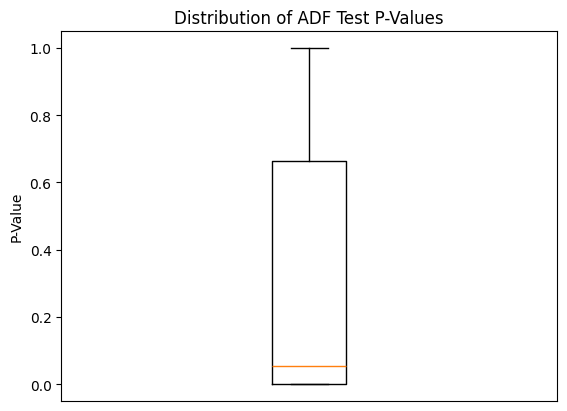

In [34]:
plt.boxplot(list(master_adf_saver['p_value']))
plt.title('Distribution of ADF Test P-Values')
plt.ylabel('P-Value')
plt.xticks([])
print(f'The median p-value of the ADF test is {master_adf_saver["p_value"].median()}')

Given the results of this test, we are unable, for many markets, to reject the null hypothesis that the data is non-stationary. 

This result is in line with our expectations. As new information is released for a given market, the mean price of that market should change, making price non-stationary.  

Therefore, we will use the first difference of price before further analysis.

In [ ]:
# Pulling out prices, leaving UNIX codes
def p_pull(clobs): 
    return [item['p'] for item in clobs]

# Applying the PACF to a given line
def p_diff(p_vec): 
    if len(p_vec) > 1:
        diff_vec = pd.Series(p_vec).diff(1).dropna().tolist()  # First difference
        return diff_vec
    else:
        return []  

j_tuples = []
master_diff = pd.DataFrame(columns=['id', 'price_diff'])

# Creating a list of tuples to iterate through our file naming convention
for j in list(range(8479, 21004, 250)): 
    if j != 20979:
        new_j = (j, j+249)
    else:
        new_j= (j, 21003)
    j_tuples.append(new_j)

# Opening each file individually, applying the PACF per line, and saving the data with IDs for indexing
for a, b in j_tuples:

    file_path = fr'C:\Users\oogim\Downloads\ECON-323---Polymarkets-1\price_data_from_{a}_to_{b}.json'
    print(a, b)
    with open(file_path, 'rb') as file:
        price_data = orjson.loads(file.read())
    print('file loaded')

    df = pd.DataFrame(price_data)

    del price_data
    gc.collect()

    df = pd.DataFrame({'id': df['identification'], 'price_vector':df['CLOB_a'].apply(p_pull)})

    df['price_diff'] = df['price_vector'].apply(p_diff)  # Apply the p_diff function to get the price difference
    df.drop(columns=['price_vector'], inplace=True)
    master_diff = pd.concat([master_diff, df], axis=0, ignore_index=True)

8479 8728
file loaded
8729 8978
file loaded
8979 9228
file loaded
9229 9478
file loaded
9479 9728
file loaded
9729 9978
file loaded
9979 10228
file loaded
10229 10478
file loaded
10479 10728
file loaded
10729 10978
file loaded
10979 11228
file loaded
11229 11478
file loaded
11479 11728
file loaded
11729 11978
file loaded
11979 12228
file loaded
12229 12478
file loaded
12479 12728
file loaded
12729 12978
file loaded
12979 13228
file loaded
13229 13478
file loaded
13479 13728
file loaded
13729 13978
file loaded
13979 14228
file loaded
14229 14478
file loaded
14479 14728
file loaded
14729 14978
file loaded
14979 15228
file loaded
15229 15478
file loaded
15479 15728
file loaded
15729 15978
file loaded
15979 16228
file loaded
16229 16478
file loaded
16479 16728
file loaded
16729 16978
file loaded
16979 17228
file loaded
17229 17478
file loaded
17479 17728
file loaded
17729 17978
file loaded
17979 18228
file loaded
18229 18478
file loaded
18479 18728
file loaded
18729 18978
file loaded
18979

In [12]:
master_diff_saver = master_diff

In [14]:
master_diff_saver.to_csv('diff_output.csv', index=False)

In [232]:
master_diff = pd.read_csv(r"C:\Users\oogim\Downloads\diff_output.csv")

In [233]:
# Converting price_diff back from a string to an array
master_diff['price_diff'] = master_diff['price_diff'].apply(lambda x: np.fromstring(x.strip('[]'), sep=','))

To check the data is now stationary, we shall run the ADF test again. 

In [54]:
loop_counter=0

# Applying the PACF to a given line
def p_adf(p_vec): 

    global loop_counter

    result = adfuller(p_vec)
    test_statistc = result[0]
    adf_p_value = result[1]
    results = np.array([test_statistc, adf_p_value])
    print(loop_counter)
    loop_counter+=1
    return results

sampled_data = pd.DataFrame(master_diff['price_diff'].sample(n=510))

sampled_data['adf'] = sampled_data['price_diff'].apply(p_adf)

In [55]:
sampled_data.to_csv('diff1_adf.csv')

In [229]:
sampled_data = pd.read_csv(r"C:\Users\oogim\Downloads\diff1_adf.csv")

In [230]:
sampled_data['adf'] = sampled_data['adf'].str.replace(r'\s+', ', ', regex=True)  # Replace spaces with commas
sampled_data['adf'] = sampled_data['adf'].apply(ast.literal_eval)

The median p-value is 0.0


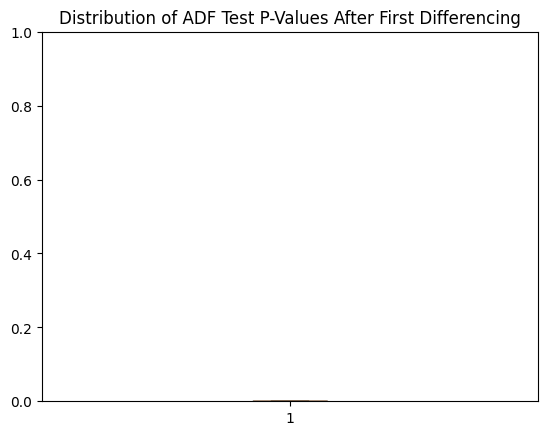

In [231]:
# Extracting the p-values from the column
plt.boxplot(sampled_data['adf'].apply(lambda x: x[1]), showfliers=False) 
plt.yticks(np.arange(0,1.2,.2))
plt.title('Distribution of ADF Test P-Values After First Differencing')
print(f'The median p-value is {(sampled_data["adf"].apply(lambda x: x[1])).median()}')

In comparison to the previous distribution of ADF p-values, we can much more conclusively say this data is stationary. 

# PACF Analysis

## Vanilla PACF

Now the data is stationary, we can test the autocorrelation of price changes. We will use the partial autocorrelation function as it breaks down how each marginal lag correlates with the price change at t. We will first find the PACF for every market. 

In [234]:
loop_counter=0

# Applying the PACF to a given line
def p_pacf(p_vec): 
    
    global loop_counter
    
    #Checking the number of price observations is at least 2 times as large as the lag period, the requirement for PACF
    if len(p_vec) > 2*lag_periods:
        
        # Progress check
        if loop_counter % 500 == 0:
            print(loop_counter)
        loop_counter+=1
        
        return pacf(p_vec, lag_periods, alpha = .05)
    else:
        return None

lag_periods = 20 # The number of periods to go back by, in minutes
master_diff['pacf'] = master_diff['price_diff'].apply(p_pacf)

In [5]:
master_diff['pacf'].loc[0]

(array([ 1.        , -0.15983009, -0.38492728, -0.04484133,  0.0255834 ,
        -0.00616354, -0.0576408 ,  0.04123184,  0.00980119,  0.03670981,
        -0.04288565, -0.01441176, -0.0099132 , -0.00362048,  0.00800459,
        -0.02403671,  0.02067407, -0.01065965,  0.00592424, -0.04720648,
        -0.02494286]),
 array([[ 1.        ,  1.        ],
        [-0.18745166, -0.13220852],
        [-0.41254885, -0.35730571],
        [-0.0724629 , -0.01721976],
        [-0.00203817,  0.05320497],
        [-0.03378511,  0.02145803],
        [-0.08526237, -0.03001923],
        [ 0.01361027,  0.06885341],
        [-0.01782038,  0.03742276],
        [ 0.00908824,  0.06433138],
        [-0.07050722, -0.01526408],
        [-0.04203333,  0.01320981],
        [-0.03753477,  0.01770837],
        [-0.03124205,  0.02400109],
        [-0.01961698,  0.03562615],
        [-0.05165828,  0.00358486],
        [-0.0069475 ,  0.04829564],
        [-0.03828122,  0.01696192],
        [-0.02169733,  0.03354581],
 

This is a sample entry from the dataframe. The first array represents the point estimate of the PACF value at each lag while the second array contains the 95% confidence interval for each lag. 

In [6]:
#Checking for NAs
master_diff[master_diff.isna()['pacf']]

,id,price_diff,pacf
3515,502515,[],None
3734,502778,[],None
4147,503252,[],None


In [ ]:
# Dropping NAs
master_pacf_saver = master_diff
master_pacf_saver = master_pacf_saver.dropna()

# Each observation in the PACF column contained two arrays: 
# 1. the point estimate of the PACF and 
# 2. the upper and lower bounds of a 95% confidence interval for each point estimate. 
# To save the data as a CSV, we converted the arrays to lists. 
master_pacf_saver['pacf'] = master_pacf_saver['pacf'].apply(lambda x: json.dumps([arr.tolist() for arr in x]))
master_pacf_saver.to_csv('diff_pacf_saved.csv', index=False)

In [41]:
new_pacf = pd.read_csv(r"C:\Users\oogim\Downloads\diff_pacf_saved.csv")
new_pacf['pacf'] = new_pacf['pacf'].apply(lambda x: [np.array(arr) for arr in json.loads(x)])
#Loading PACF data back in and changing the 'pacf' column back from a string into a list of arrays

Now, we wanted a dataframe where the index was each market ID, and the columns were each period of the PACF. 

In [42]:
point_est = new_pacf['pacf'].apply(lambda x: x[0]) # Pulling out the point estimates
point_est = point_est.tolist()
point_est = pd.DataFrame(point_est)
point_est['id'] = new_pacf['id'] # Adding the associated IDs
point_est = point_est.set_index('id')
point_est = point_est.drop(columns=[0]) # Dropping the first column as it is always 1
point_est.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
id,,,,,,,,,,,,,,,,,,,,
253353,-0.159830,-0.384927,-0.044841,0.025583,-0.006164,-0.057641,0.041232,0.009801,0.036710,-0.042886,-0.014412,-0.009913,-0.003620,0.008005,-0.024037,0.020674,-0.010660,0.005924,-0.047206,-0.024943
253354,-0.138310,-0.022690,-0.003653,-0.000909,0.000178,-0.002349,0.002385,0.000798,0.000195,-0.000438,0.001948,-0.002251,-0.003863,-0.001391,-0.000203,-0.000063,-0.008275,0.004334,0.005214,-0.003343
253355,-0.024058,-0.002642,0.000180,-0.002025,-0.000944,-0.005381,-0.050222,0.020589,0.048028,0.002404,-0.002219,-0.012523,-0.001006,-0.021273,-0.022564,0.008596,-0.001739,-0.002792,-0.015083,-0.022552
253356,-0.410209,-0.202681,-0.104669,-0.054670,-0.028659,-0.015202,-0.008083,-0.004315,-0.002322,-0.001267,-0.000636,-0.000337,-0.000198,-0.000133,-0.034566,0.081597,0.095057,0.078197,0.056646,0.038469
253358,-0.004583,0.000402,-0.005879,0.000087,-0.000039,0.010691,-0.006933,-0.000114,0.000128,-0.000085,0.011491,0.005446,0.000553,0.001486,-0.005605,0.000025,-0.001327,0.048336,0.001599,0.005322


Now that the PACF data is clean, we can plot the output for each lag across all markets. 

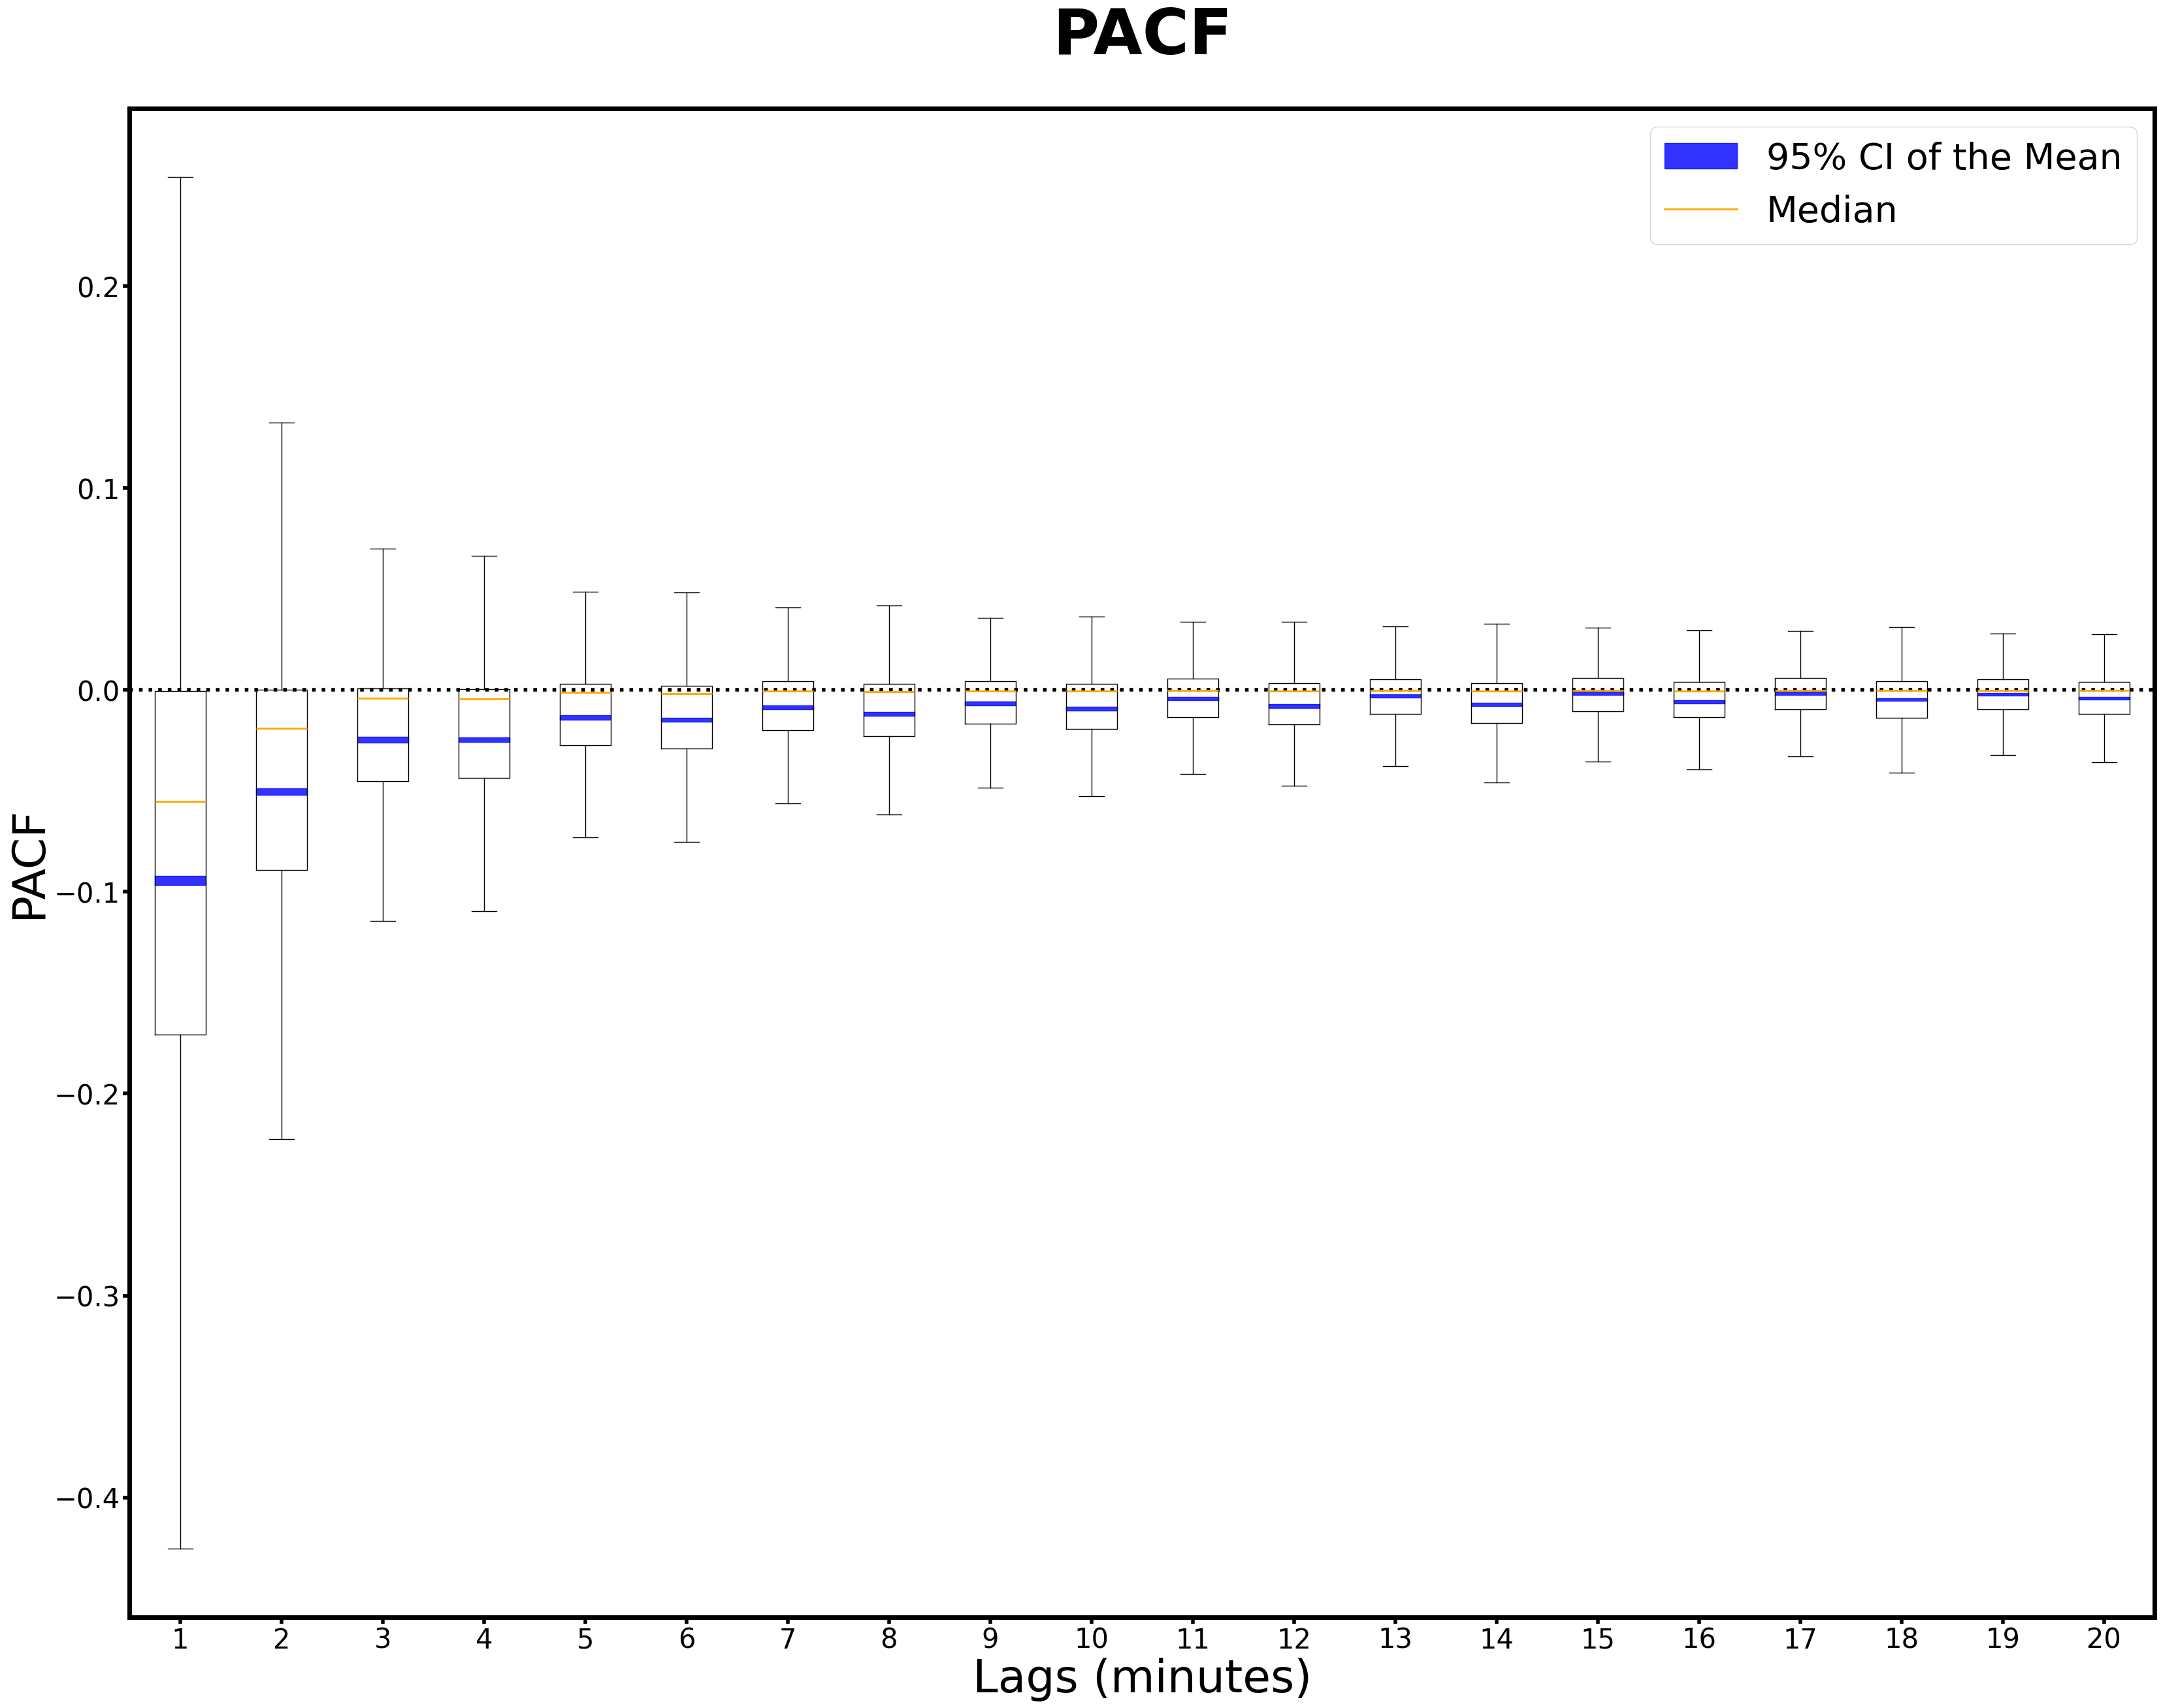

In [43]:
fig, ax = plt.subplots(figsize=(40,30))
ax.boxplot(point_est, showfliers=False, medianprops={'color':'orange', 'linewidth':2})

# Creating the confidence intervals for each mean on each boxplot
for i in range(1,21):
    mean = np.mean(point_est[i])
    sem = stats.sem(point_est[i])
    plt.fill_between([i - 0.25, i +.25], mean - 1.96*sem, mean + 1.96*sem, color = 'blue', alpha=.8)


# Formatting the chart
plt.title('PACF', fontweight = 'bold', fontsize = 70, pad = 60)
plt.ylabel('PACF', fontsize = 50)
plt.xlabel('Lags (minutes)', fontsize = 50)
plt.xticks(list(range(1, 21)), list(range(1,21)), fontsize = 30)
plt.yticks(fontsize = 30)
for spine in ax.spines.values():
    spine.set_linewidth(5)
plt.tick_params(axis='both', width = 4, length = 7)
ax.axhline(y=0, color='black', linestyle=':', linewidth=4)

# Formatting the legend
ax.fill_between([], [], color='blue', alpha=0.8, label='95% CI of the Mean')  # Dummy plot for CI
ax.plot([], [], color='orange', lw=2, label='Median')  # Dummy plot for median
plt.legend(fontsize=40)

plt.show()

Before analyzing this PACF plot, what would we expect it to look like for a set of perfectly efficient markets?

The PACF value for every lag period should tend towards zero. Previous price changes should provide no information on future price changes. Once new information for a market is released, price should adjust immediately. Further, the only time price should change is when new information is released. Therefore, changes in price would be a largely random process, influenced only by updates in the market's estimate of the true probability of the outcome.

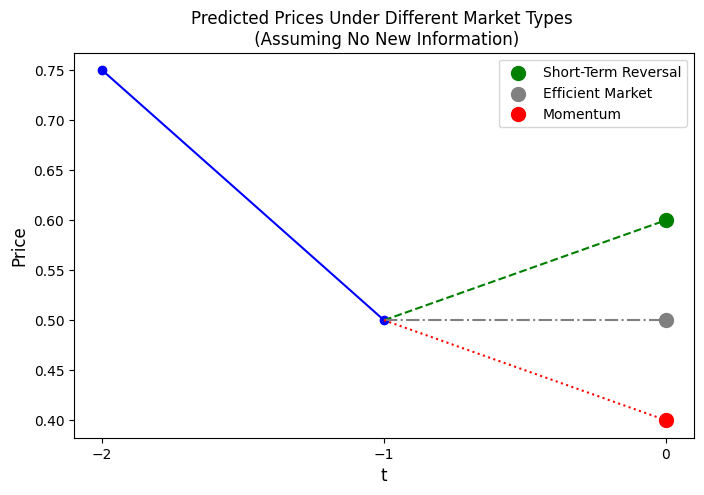

In [70]:
# Creating a plot to demonstrate the following examples

dummy_price = [0.75, 0.5]

# Plot the original data
plt.figure(figsize=(8, 5))
plt.plot([-2,-1],dummy_price,marker='o', label='Actual Values', color='blue')

# Store values and style info for each potential value
potential_values = [
    {'value': 0.6, 'line_style': '--', 'color': 'green', 'marker': 'o', 'label': 'Short-Term Reversal'},
    {'value': 0.5, 'line_style': '-.', 'color': 'grey', 'marker': 'o', 'label': 'Efficient Market'},
    {'value': 0.4, 'line_style': ':', 'color': 'red', 'marker': 'o', 'label': 'Momentum'},
]

# Plot potential values
dots =[] # Store handles for dots for the legend
for potential in potential_values:
    plt.plot(
        [-1, 0], 
        [dummy_price[-1], potential['value']], 
        linestyle=potential['line_style'], 
        color=potential['color'], 
        label=potential['label']
    )
    dot = plt.scatter(
        0, 
        potential['value'], 
        color=potential['color'], 
        marker=potential['marker'], 
        s=100,  # Adjust marker size if needed
        label=f"{potential['label']}"
    )
    dots.append(dot)

plt.legend(handles=dots)
plt.title('Predicted Prices Under Different Market Types \n (Assuming No New Information)')
plt.xlabel('t', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(range(-2, 1))  # Adjust x-ticks for clarity
plt.show()


Imagine price was .75 at t-2 and .5 at t-1, we would assume information was released that altered the market's estimate. Our new best guess as to the price at t would be the price at t-1. We would ignore the change in price entirely, thus making the PACF values for the first difference all 0 in the long-run.

Knowing this, we can now compare the theoretical efficient market to our own output. 

The first difference of price, FD(p), at t-1 is negatively correlated with FD(p) at t. This points to short term reversal.

Again imagine price was .75 at t-2 and .5 at t-1. FD(p) at t-1 would be -.25. Given FD(p) at t-1 has a negative PACF value, our estimate of FD(p) at t would now increase. This is short-term reversal; negative returns at t-1 increase our expectation of returns at t. 

As we don't have order flow or order book data, we can only guess as to the cause of these results. However, given our intial price data represented the midpoint, it is fair to assume this is at least partially the result of Polymarket's low liquidity. 

To demonstrate this, we can add to the previous example. Imagine price had remained constant for many periods up to t-2, when the midpoint was .75 with a spread of .02. Between t-2 and t-1, a block of shares is sold for non-fundamental reasons. The best bid at t-1 is pushed down to .25. The midpoint (.51) would now contain less information on the market's true estimate of the probability than it did at t-2. We would expect new liquidity to fill the order book, pushing the best bid up, closer to its previous value at t-2. In this case, negative returns in the previous period, caused by low liquidity, increase our estimate of returns in the next period. This is why low liquidity may be the cause of these observations. 

There is, however, significant variance in the PACF values. Some markets point instead towards momentum. Focusing on the long top whisker on the box at t-1, we can see that, for some markets, FD(p) at t-1 is positively correlated with FD(p) at t. 

Again imagine a market where price is .75 at t-2 and .5 and t-1. If FD(p) at t-1 is positively correlated with FD(p) at t, given this decrease in price, our expectation of FD(p) at t would decrease. This is momentum; if price previously decreased, our expectation of future returns decreases, and vice versa.

Given there is significant variance on each lag, we woud like to further group these markets. However, we don't have the obvious data to do this: order flow and spread. Therefore, we will first try and group by the market categories from Polymarket's API. Ideally, each grouping would exhibit only one of the following:
1. Short-Term Reversal
2. Momentum
3. Efficient (PACF values of 0)


## PACF Grouped by Market Topic

### Attempt to Pull Categories from API

Our attempt at pulling the 'category' variable from Polymarket's API. 

In [7]:
#pulling categories from the main database again

cat_data = pd.DataFrame(columns = ['identification', 'category'])

def appender(x):
    global cat_data
    new_row = pd.DataFrame([{
        "identification": x['id'],
        "category": x["category"]}])
    cat_data = pd.concat([cat_data, new_row], ignore_index=True)

# Offset Loop
for i in range(215, 1100):
    offset = i * 20 # Updates offset parameter 
    url = f"https://gamma-api.polymarket.com/markets?offset={offset}" # Updated offset
    print(i)
    
    response = rq.get(url) # Gets data from the API
    
    # Check for okay
    if response.status_code == 200:
        results = pd.DataFrame(response.json())
        results.apply(appender, axis=1)
    else:
        print(f"Failed to retrieve data at offset {offset}") #error message for failed loop
        break  # break to end loop

print(f"Total entries: {len(data)}")

215
216
217
218
219
220


KeyError: 'category'

In [ ]:
cat_data.isna().sum() # Checking how many were empty before the field was deleted from the API's dataset entirely

identification     0
category          13
dtype: int64

They seemingly stopped storing category data at around market 4400, as the error was thrown when offset was 220 (220*20 = 4400). This is far before they started storing useful price data (market 8479).

### LLM Question Categorization 

To create our own groupings by topic, we thought we may be able to feed each market's question (e.g. "Wil Trump Get Elected?") into an LLM for labelling.

We first isolated the question and ID columns and made a new dataframe.

In [39]:
data_df_good = pd.read_csv(r"C:\Users\oogim\Downloads\ECON-323---Polymarkets-1\new_polydata.csv")
bool_list = ~data_df_good['clobTokenIds'].isna() #filtering out Nan CLOB tokens
data_df_best = data_df_good.loc[bool_list].reset_index(drop=True)

In [ ]:
questions_clean = data_df_best[['id', 'question']][8479:]
questions_clean.to_csv('questions_saved', index=False)

In [3]:
questions_clean = pd.read_csv(r"C:\Users\oogim\Downloads\questions_saved")

In [4]:
questions_clean

,id,question
0,253353,Will Shohei Ohtani sign with Blue Jays?
1,253354,Pudgy Penguins airdrop before March?
2,253355,Taylor Swift pregnant before March?
3,253356,Will Chris Christie drop out of presidential r...
4,253358,Will Zelensky remain President of Ukraine thro...
...,...,...
12520,512457,Will Gallego win Arizona Senate election by 0-1%?
12521,512458,Will Kari Lake win Arizona Senate election by ...
12522,512459,Will Kari Lake win Arizona Senate election by ...
12523,512460,Will Kari Lake win Arizona Senate election by ...


We are using Facebook's BART Multi-Label Natural Language Inference (MNLI) Model. It intakes two pieces of text, a premise and a hypothesis, and predicts their logical relationship. To use this, we can take each question as a premise, and compare it to each category as a hypothesis. It will then score how well each question relates to each category, selecting the category with the highest score. As we will not be providing any training data, this is a zero-shot classification. 

In [ ]:
output_df = pd.DataFrame(columns = ['question', 'category', 'score'])

# Defining a function to classify each column in the dataframe
def classify(x):
    
    global output_df
    
    # Placing the string into one of the given categories
    result = classifier(x, candidate_labels=categories)
    
    # Progress check
    print(f"Text: {x}")
    print(f"Category: {result['labels'][0]}, Score: {result['scores'][0]:.4f}")
    print("-" * 40)

    # Creating a row out of the data
    new_row = pd.DataFrame({'question':[x], 'category': [result['labels'][0]], 'score': [result['scores'][0]]})
    
    # Adding it to the master dataframe
    output_df = pd.concat([output_df, new_row])    

# Creating our classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# The buckets were initially taken from Polymarket's site, and then pared down to remove ambiguous labels like 'mentions'.
# After testing, it was clear it did not know how to categorize 'xyz airdrop by June 30th?', so we added 'airdrops' to the crypto label. 
# Further, it was categorizing Fed policy bets into both politics and economics, so we added 'interest rates' to the Econ label to ensure they were grouped together. 
categories = ['Sports', 'Politics', 'Cryptocurrency and Airdrops', 'Pop Culture,', 'Business, Economics, Interest Rates', 'Science']

texts = questions_clean['question']

texts.apply(classify)

Examplar output from the cell above:

Text: Will Shohei Ohtani sign with Blue Jays?
Category: Sports, Score: 0.8777

Text: Pudgy Penguins airdrop before March?
Category: Pop Culture,, Score: 0.3784

Text: Taylor Swift pregnant before March?
Category: Pop Culture,, Score: 0.7482
...

Text: Trump transgender sports ban?
Category: Sports, Score: 0.7918

In [103]:
score_df = pd.merge(output_df, data_df_best, on='question', how='left').drop(columns =['clobTokenIds'])
clean_score_df = score_df[~score_df.duplicated(subset='id',keep='first')]

score_df.to_csv('dirtyscores', index=False)
clean_score_df.to_csv('cleanscores', index=False)

In [8]:
clean_score_df = pd.read_csv(r"C:\Users\oogim\Downloads\cleanscores")

In [9]:
clean_score_df.head()

,question,category,score,id,createdAt,closedTime
0,Will Shohei Ohtani sign with Blue Jays?,Sports,0.877725,253353,2023-12-08T16:14:08.517Z,2023-12-12 04:17:10+00
1,Pudgy Penguins airdrop before March?,"Pop Culture,",0.378441,253354,2023-12-08T16:32:56.98Z,2024-03-01 07:34:25+00
2,Taylor Swift pregnant before March?,"Pop Culture,",0.748164,253355,2023-12-08T16:39:37.985Z,2024-03-01 07:18:04+00
3,Will Chris Christie drop out of presidential r...,Politics,0.921929,253356,2023-12-08T16:53:07.814Z,2024-01-01 07:19:19+00
4,Will Zelensky remain President of Ukraine thro...,Politics,0.833661,253358,2023-12-08T17:31:45.189Z,2024-04-01 06:06:06+00


In [10]:
# Merging with the PACF data
PACFs_cat = pd.merge(point_est, clean_score_df, left_index=True, right_on= 'id', how='left') 

In [265]:
PACFs_cat.to_csv(r'newPACFSbycategory.csv')

In [13]:
PACFs_cat = pd.read_csv(r"C:\Users\oogim\Downloads\newPACFSbycategory.csv")

To analyze this data, we can create a dataframe including the PACF lags and the category score as the columns and the category label as the index. 

In [14]:
point_est_categories = PACFs_cat.drop(columns=['question', 'id', 'createdAt', 'closedTime', 'cluster', "Unnamed: 0"])
point_est_categories['category'] = point_est_categories['category'].replace('Pop Culture,', 'Pop Culture').replace('Business, Economics, Interest Rates','Biz, Econ, & Int. Rates').replace('Cryptocurrency and Airdrops', 'Crypto') # Renaming for the visualization
point_est_categories.set_index('category', drop=True, inplace=True)
point_est_categories.head()

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,score
category,,,,,,,,,,,,,,,,,,,,,
Sports,-0.159830,-0.384927,-0.044841,0.025583,-0.006164,-0.057641,0.041232,0.009801,0.036710,-0.042886,...,-0.009913,-0.003620,0.008005,-0.024037,0.020674,-0.010660,0.005924,-0.047206,-0.024943,0.877725
Pop Culture,-0.138310,-0.022690,-0.003653,-0.000909,0.000178,-0.002349,0.002385,0.000798,0.000195,-0.000438,...,-0.002251,-0.003863,-0.001391,-0.000203,-0.000063,-0.008275,0.004334,0.005214,-0.003343,0.378441
Pop Culture,-0.024058,-0.002642,0.000180,-0.002025,-0.000944,-0.005381,-0.050222,0.020589,0.048028,0.002404,...,-0.012523,-0.001006,-0.021273,-0.022564,0.008596,-0.001739,-0.002792,-0.015083,-0.022552,0.748164
Politics,-0.410209,-0.202681,-0.104669,-0.054670,-0.028659,-0.015202,-0.008083,-0.004315,-0.002322,-0.001267,...,-0.000337,-0.000198,-0.000133,-0.034566,0.081597,0.095057,0.078197,0.056646,0.038469,0.921929
Politics,-0.004583,0.000402,-0.005879,0.000087,-0.000039,0.010691,-0.006933,-0.000114,0.000128,-0.000085,...,0.005446,0.000553,0.001486,-0.005605,0.000025,-0.001327,0.048336,0.001599,0.005322,0.833661


([], [])

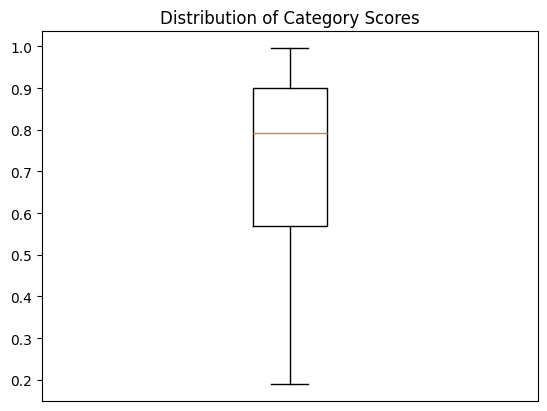

In [15]:
plt.boxplot(point_est_categories['score'])
plt.title('Distribution of Category Scores')
plt.xticks([])

In [16]:
categorized = point_est_categories.groupby(point_est_categories.index)

Text(0, 0.5, 'Score')

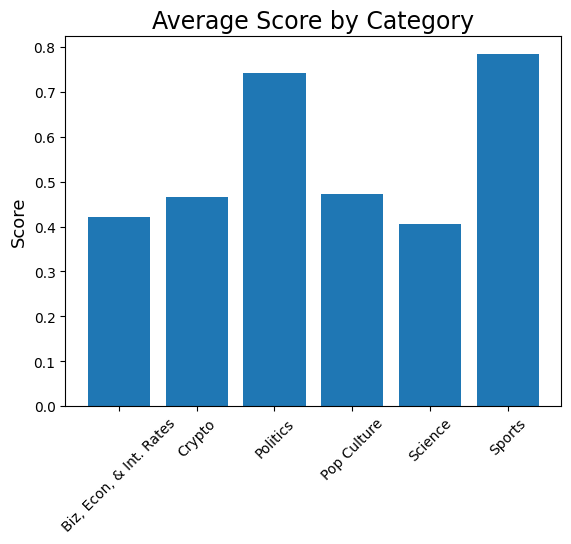

In [17]:
bar_data_df = categorized['score'].mean()
plt.bar(bar_data_df.index, bar_data_df.values)
plt.xticks(rotation=45)
plt.title('Average Score by Category', size=17)
plt.ylabel('Score', size=13)

From this, we can see that only the questions within the Politics and Sports categories were fit well by the model. This means we may have a hard time capturing any differences between the other categories.

Text(0, 0.5, 'Count')

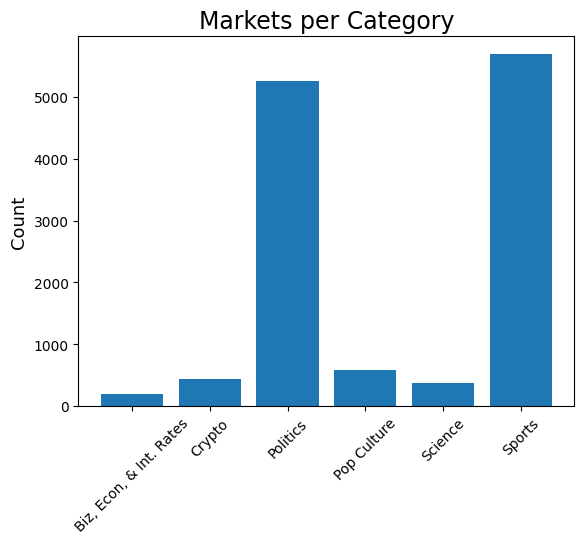

In [18]:
plt.bar(categorized.size().index, categorized.size().values)
plt.xticks(rotation=45)
plt.title('Markets per Category', size=17)
plt.ylabel('Count', size=13)

The zero-shot model clearly had a hard time evaluating aspects of a question that were unrelated to sports or politics. Given these two groups are so prevalent in the dataset, before further comparison, we will undersample such that we include an equal number of each grouping. 

In [19]:
# Dropping score to plot PACFs
categorized = point_est_categories.drop(columns=['score']).groupby(point_est_categories.index)
min_group_size = categorized.size().min()

categorized_sample = pd.DataFrame()

# Undersampling
for category, group in categorized:
    group_undersampled = resample(group, replace=False, n_samples=min_group_size)
    categorized_sample = pd.concat([categorized_sample, group_undersampled])

# Grouping by category
grouped_cat_sample = categorized_sample.groupby(categorized_sample.index)
grouped_cat_sample.head(1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
category,,,,,,,,,,,,,,,,,,,,
"Biz, Econ, & Int. Rates",-0.249999,-0.146892,-0.032448,-3.175365e-02,-9.962067e-03,-0.004796,-5.774931e-03,-0.095429,0.045761,0.086375,-0.019066,-0.014504,0.002318,0.007222,4.118464e-03,-5.717408e-03,0.005649,0.007584,-0.012856,0.000138
Crypto,-0.114769,-0.016535,-0.216848,-6.366529e-02,-8.441980e-03,-0.043743,-1.586664e-02,0.000902,0.011568,-0.067180,-0.023444,-0.021356,-0.012213,-0.011033,-1.339770e-02,3.707663e-03,-0.005663,-0.122860,-0.033458,-0.012389
Politics,-0.064996,0.073835,-0.022472,2.058952e-03,1.127057e-02,0.031604,-3.663782e-02,0.002573,-0.005368,-0.012892,-0.009248,0.005316,0.002277,0.005205,1.334944e-03,-3.156352e-03,-0.001355,0.001648,0.001798,-0.000394
Pop Culture,0.025007,-0.004479,0.003466,1.320114e-03,-2.975366e-02,-0.037973,3.386788e-03,-0.000871,0.000143,-0.001053,-0.011648,-0.012968,0.000651,-0.000219,-2.188357e-03,-5.418946e-04,-0.001942,0.000067,0.000054,-0.000772
Science,-0.079632,-0.025812,-0.045459,-3.459487e-02,-2.803695e-02,-0.056233,-8.233593e-02,-0.045650,-0.048180,-0.014475,-0.034478,-0.012061,-0.030075,-0.037407,3.213012e-02,-1.657281e-02,-0.020593,-0.012695,0.000590,0.005010
Sports,-0.000178,-0.000267,-0.000045,-1.031050e-07,-3.970790e-08,-0.000089,-4.766587e-08,0.000089,-0.000045,0.000045,-0.104917,-0.000082,-0.000012,0.000037,-2.214224e-08,-9.934804e-07,0.000117,-0.000045,-0.000344,-0.000149


In [20]:
# Plotting the PACFs by Category
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(100,80), sharey=True)
axs = axs.flatten()

plot_num = 0 

for group_name, group in grouped_cat_sample:

    ax = axs[plot_num]
    values = group.values

    ax.boxplot(group, showfliers=False, medianprops={'color':'orange','linewidth':2})

    for i in range(values.shape[1]):
        mean = np.mean(values[:, i])
        sem = stats.sem(values[:, i])
        ax.fill_between([i + 1 - 0.25, i + 1 +.25], mean - 1.96*sem, mean + 1.96*sem, color = 'blue')

    ax.set_title(group_name, fontsize=80, pad=20)
    ax.set_xticks(range(1, 21))
    ax.set_xticklabels(range(1, 21), fontsize=40)
    ax.tick_params(axis='both', labelsize=40)
    ax.axhline(y=0, color='black', linestyle=':', linewidth=2)


    plot_num +=1


# Formatting the legend
ax.fill_between([], [], color='blue', alpha=0.8, label='95% CI of the Mean')  # Dummy plot for CI
ax.plot([], [], color='orange', lw=5, label='Median')  # Dummy plot for median
fig.legend(bbox_to_anchor=(1.1,.53),fontsize=100, frameon=True).get_frame().set_linewidth(10)


fig.text(.5, .92, 'PACF by Category', ha='center', fontsize=250, fontweight='bold')
fig.text(0.09, 0.5, 'PACF', va='center', rotation='vertical', fontsize=100, fontweight='bold')
fig.text(0.5, 0.075, 'Period', ha='center', fontsize=100, fontweight='bold')
plt.show()

Visually, it is hard to see any differentiation between the categories. We can use a MANOVA to test the signfiicance of the difference between the sets of distributions in each cluster.

In [21]:
# Creating a df that fits the requirements for the MANOVA
manova_df_LLM = categorized_sample.reset_index()
new_columns = ['cluster'] + [f't{i}' for i in range(1,21)]
manova_df_LLM.columns = new_columns
manova_df_LLM.head()

,cluster,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20
0,"Biz, Econ, & Int. Rates",-0.249999,-0.146892,-0.032448,-0.031754,-0.009962,-0.004796,-0.005775,-0.095429,0.045761,...,-0.019066,-0.014504,0.002318,0.007222,0.004118,-0.005717,0.005649,7.584123e-03,-0.012856,0.000138
1,"Biz, Econ, & Int. Rates",-0.000001,-0.000138,-0.000089,-0.000002,-0.000036,0.000003,0.000030,-0.000003,-0.000001,...,-0.000001,-0.000009,0.000013,-0.000005,-0.000120,-0.000016,-0.000002,-2.548305e-08,-0.000034,-0.000002
2,"Biz, Econ, & Int. Rates",-0.019230,-0.012418,-0.105889,-0.011831,-0.008674,0.009663,-0.014837,-0.008366,0.002428,...,-0.005364,0.008516,0.006350,0.005867,0.004041,0.002078,0.001730,-5.811888e-04,0.003610,-0.006290
3,"Biz, Econ, & Int. Rates",0.000009,-0.666569,-0.000075,-0.212077,-0.000127,0.232256,0.000075,0.325521,0.008055,...,0.005277,-0.125859,-0.000749,-0.211120,-0.002108,-0.096201,0.000580,8.145253e-02,0.002076,0.151762
4,"Biz, Econ, & Int. Rates",-0.030040,0.004164,-0.120242,0.005235,-0.028847,-0.015536,0.000953,-0.004489,-0.003568,...,0.000840,-0.000985,0.025143,-0.001710,-0.001045,-0.104697,-0.011543,-4.986876e-02,-0.031737,-0.013052


In [22]:
dependent_vars = ' + '.join(new_columns[1:21])
formula = f"{dependent_vars} ~ cluster"
manova_LLM = MANOVA.from_formula(formula, data=manova_df_LLM)
manova_LLM_result = manova_LLM.mv_test()
print(manova_LLM_result)

                   Multivariate linear model
                                                                
----------------------------------------------------------------
        Intercept        Value   Num DF   Den DF  F Value Pr > F
----------------------------------------------------------------
           Wilks' lambda 0.8525 20.0000 1145.0000  9.9034 0.0000
          Pillai's trace 0.1475 20.0000 1145.0000  9.9034 0.0000
  Hotelling-Lawley trace 0.1730 20.0000 1145.0000  9.9034 0.0000
     Roy's greatest root 0.1730 20.0000 1145.0000  9.9034 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
        cluster         Value   Num DF    Den DF  F Value Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.8705 100.0000 5590.5742  1.6120 0.0001
         Pillai's trace 0.1359 100.0000 5745.

The null hypothesis of this test is that the sets of distributions are equal across groups. Given the p-value for both the overall model and the cluster factor are 0, we can reject the null hypothesis at a 5% significance level. However, the difference does not seemingly manifest in any meaningful way. 

## PACF Grouped through K-Means Clustering

### PACF by K-Means Clusters

As an alternate method of grouping our markets, we will now use k-means clustering. There may be patterns in the PACF values for markets caused by liquidity and volume that we are otherwise unable to identify. Through k-means clustering, we therefore may be able to capture this information. Ideally, these clusters will be isolate the different market types previously outlined: short-term reversal, momentum, and efficient.

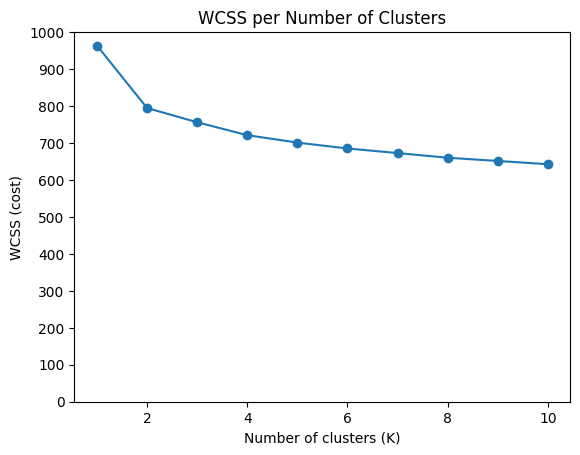

In [44]:
point_est_nonPCA = point_est

# Calculating WCSS for values of k from to 10. 
wcss_scores = []
for k in range(1, 11): 
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(point_est_nonPCA) 
    wcss_scores.append(kmeans.inertia_)

# Plotting WCSS values
plt.plot(range(1, 11), wcss_scores, marker='o')
plt.title('WCSS per Number of Clusters')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (cost)')
plt.yticks(range(0, 1100, 100))
plt.show()

This plot shows the within-cluster sum of squares (WCSS) and how it changes based on the number of clusters we use. The within-cluster sum of squares measures the sum of the squared distances of each point from it's respective centroid. Based on the Elbow heuristic, where one uses the number of clusters required before the marginal reduction in WCSS plateaus, we selected 2 for our k. 

In [45]:
nonPCA_cluster_count = 2

In [46]:
kmeans = KMeans(n_clusters=nonPCA_cluster_count)  # Adjust n_clusters as needed
point_est_nonPCA['cluster'] = kmeans.fit_predict(point_est_nonPCA)
point_est_nonPCA = point_est_nonPCA.set_index(point_est_nonPCA['cluster']).drop(columns=['cluster'])
point_est = point_est.drop(columns=['cluster'])
point_est_nonPCA.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
cluster,,,,,,,,,,,,,,,,,,,,
0,-0.159830,-0.384927,-0.044841,0.025583,-0.006164,-0.057641,0.041232,0.009801,0.036710,-0.042886,-0.014412,-0.009913,-0.003620,0.008005,-0.024037,0.020674,-0.010660,0.005924,-0.047206,-0.024943
1,-0.138310,-0.022690,-0.003653,-0.000909,0.000178,-0.002349,0.002385,0.000798,0.000195,-0.000438,0.001948,-0.002251,-0.003863,-0.001391,-0.000203,-0.000063,-0.008275,0.004334,0.005214,-0.003343
1,-0.024058,-0.002642,0.000180,-0.002025,-0.000944,-0.005381,-0.050222,0.020589,0.048028,0.002404,-0.002219,-0.012523,-0.001006,-0.021273,-0.022564,0.008596,-0.001739,-0.002792,-0.015083,-0.022552
0,-0.410209,-0.202681,-0.104669,-0.054670,-0.028659,-0.015202,-0.008083,-0.004315,-0.002322,-0.001267,-0.000636,-0.000337,-0.000198,-0.000133,-0.034566,0.081597,0.095057,0.078197,0.056646,0.038469
1,-0.004583,0.000402,-0.005879,0.000087,-0.000039,0.010691,-0.006933,-0.000114,0.000128,-0.000085,0.011491,0.005446,0.000553,0.001486,-0.005605,0.000025,-0.001327,0.048336,0.001599,0.005322


In [47]:
cluster_groups_nonPCA = point_est_nonPCA.groupby(point_est_nonPCA.index)
cluster_groups_nonPCA.size()

cluster
0    3873
1    8649
dtype: int64

Now, we can plot the PACF values by cluster, to see if there are significant differences. 

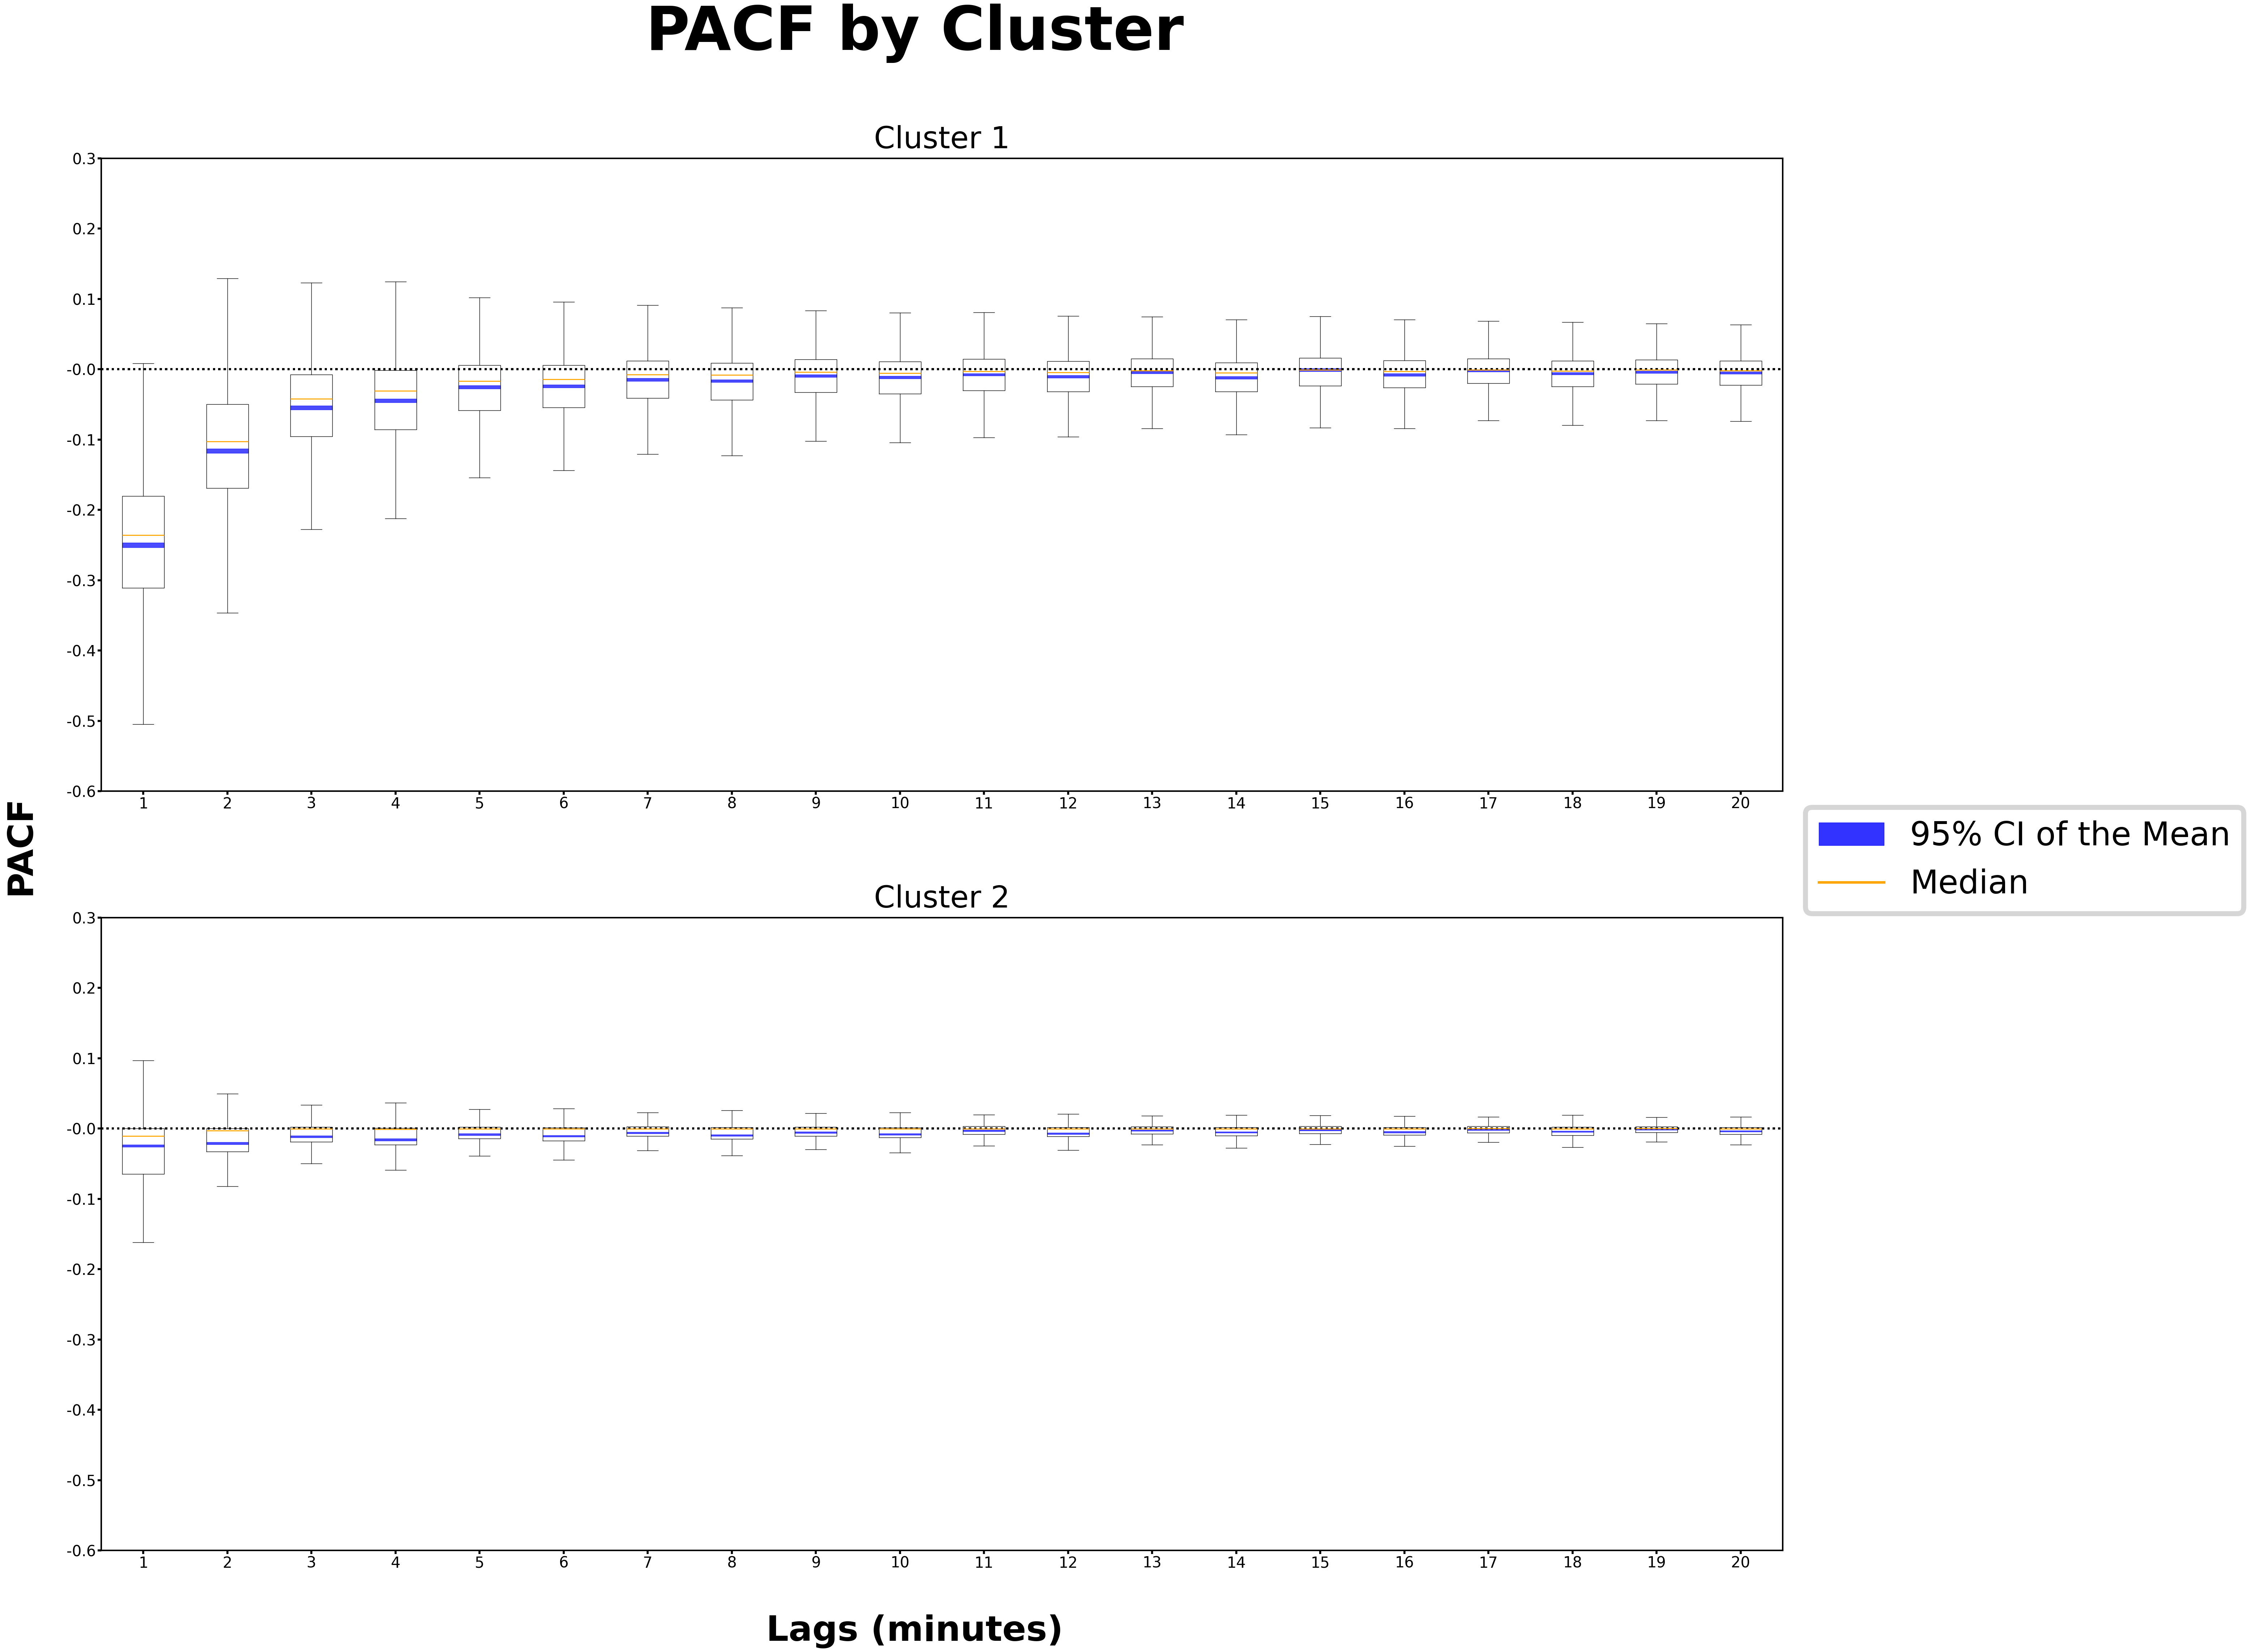

In [48]:
fig, ax_clustered = plt.subplots(nrows=nonPCA_cluster_count, ncols=1, figsize=(60,50))

ax_clustered=ax_clustered.flatten()

# Plotting each cluster
for i, (group_name, group) in enumerate(cluster_groups_nonPCA):
    
    ax_clustered[i].boxplot(group, showfliers=False, medianprops={'color':'orange','linewidth':2})    
    
    
    # Plotting the values for each lag
    for z in range(0,20):
 
        # Adding confidence intervals for the mean
        mean = np.mean(group.iloc[:, z])
        sem = stats.sem(group.iloc[:, z])
        ax_clustered[i].fill_between([z+1 - 0.25, z+1 +.25], mean - 1.96*sem, mean + 1.96*sem, alpha = .7, color = 'blue')

        # Formatting
        ax_clustered[i].set_title(f'Cluster {i+1}', fontsize=60, pad=20)
        ax_clustered[i].set_xticks(range(1, 21))
        ax_clustered[i].set_xticklabels(range(1,21), size = 30)
        for spine in ax_clustered[i].spines.values():
            spine.set_linewidth(3)
        ax_clustered[i].tick_params(axis='both', width = 4, length = 7)
        ax_clustered[i].axhline(y=0, color='black', linestyle=':', linewidth=4)

# Formatting the legend
ax_clustered[0].fill_between([], [], color='blue', alpha=0.8, label='95% CI of the Mean')  # Dummy plot for CI
ax_clustered[0].plot([], [], color='orange', lw=5, label='Median')  # Dummy plot for median
fig.legend(bbox_to_anchor=(1.12,.53),fontsize=65, frameon=True).get_frame().set_linewidth(10)

# Outside of the loop as, for some reason, this wasn't being correctly iterated over
ax_clustered[0].set_yticks(np.arange(-.6,.4,0.1))
ax_clustered[0].set_yticklabels(np.arange(-.6,.4,0.1).round(2),size=30)
ax_clustered[1].set_yticks(np.arange(-.6,.4,0.1))
ax_clustered[1].set_yticklabels(np.arange(-.6,.4,0.1).round(2),size=30)

fig.text(0.5, .94, 'PACF by Cluster', ha='center', fontsize=120, fontweight='bold')
fig.text(0.08, 0.5, 'PACF', va='center', rotation='vertical', fontsize=70, fontweight='bold')
fig.text(0.5, 0.06, 'Lags (minutes)', ha='center', fontsize=70, fontweight='bold')
plt.show()

Looking at these distributions, we can now more clearly see two of the three types: short-term reversal in cluster 1, and efficiency in cluster 2. 

In cluster 1, for at least FD(p) at t-1, we see a significant negative correlation with FD(p) at t. The blue shaded area, representing a 95% confidence interval for the mean, shows us that the mean at lag 1 is statistically significant from 0. From this we can likely conclude Cluster 1's PACF value for FD(p) at lag 1 is likely below 0. 

However, it may still be inconclusive, as this is effeictively a two-tail t-test with a null hypothesis of mu=0. One-sample t-tests does not check for cross-correlation between markets. Therefore, cluster 1 may share negative PACF values due to, for example, a long period where the markets were based on similar underlying events. This, however, is unlikely to be a significant problem, as we included thousands of markets across many years. 

Going back to the relationship between negative PACF values and short-term reversal, and assuming the t-test is valid, we can thus conclude that cluster 1, to varying degerees across lags, demonstrates short-term reversal characteristics consistent with markets of low liquidity. 

Cluster 2, in contrast, approaches our PACF plot for an efficient market. Comparatively, previous price changes contain little to no information on future price changes, consistent with our understanding of a theoretical efficient market. 

Using k-means clustering, we have thus managed to delineate between inefficient and pseudo-efficient markets. 

While it is visually apparent, to prove a statistically significant difference between the two clusters, we can apply a MANOVA test. The null hypothesis for this test being that each cluster has identical sets of distributions. 

In [49]:
# Creating a df consistent with the requirements for a MANOVA

manova_df_nonPCA = point_est_nonPCA.reset_index()
manova_df_nonPCA.columns = new_columns
manova_df_nonPCA.head()

,cluster,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20
0,0,-0.159830,-0.384927,-0.044841,0.025583,-0.006164,-0.057641,0.041232,0.009801,0.036710,...,-0.014412,-0.009913,-0.003620,0.008005,-0.024037,0.020674,-0.010660,0.005924,-0.047206,-0.024943
1,1,-0.138310,-0.022690,-0.003653,-0.000909,0.000178,-0.002349,0.002385,0.000798,0.000195,...,0.001948,-0.002251,-0.003863,-0.001391,-0.000203,-0.000063,-0.008275,0.004334,0.005214,-0.003343
2,1,-0.024058,-0.002642,0.000180,-0.002025,-0.000944,-0.005381,-0.050222,0.020589,0.048028,...,-0.002219,-0.012523,-0.001006,-0.021273,-0.022564,0.008596,-0.001739,-0.002792,-0.015083,-0.022552
3,0,-0.410209,-0.202681,-0.104669,-0.054670,-0.028659,-0.015202,-0.008083,-0.004315,-0.002322,...,-0.000636,-0.000337,-0.000198,-0.000133,-0.034566,0.081597,0.095057,0.078197,0.056646,0.038469
4,1,-0.004583,0.000402,-0.005879,0.000087,-0.000039,0.010691,-0.006933,-0.000114,0.000128,...,0.011491,0.005446,0.000553,0.001486,-0.005605,0.000025,-0.001327,0.048336,0.001599,0.005322


In [50]:
dependent_vars = ' + '.join(new_columns[1:21])
formula = f"{dependent_vars} ~ cluster"
manova_nonPCA = MANOVA.from_formula(formula, data=manova_df_nonPCA)
manova_nonPCA_result = manova_nonPCA.mv_test()
print(manova_nonPCA_result)

                    Multivariate linear model
                                                                  
------------------------------------------------------------------
       Intercept        Value   Num DF   Den DF    F Value  Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.2078 20.0000 12501.0000 2382.3678 0.0000
         Pillai's trace 0.7922 20.0000 12501.0000 2382.3678 0.0000
 Hotelling-Lawley trace 3.8115 20.0000 12501.0000 2382.3678 0.0000
    Roy's greatest root 3.8115 20.0000 12501.0000 2382.3678 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
        cluster         Value   Num DF   Den DF    F Value  Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.3326 20.0000 12501.0000 1254.2339 0.0000
         Pillai'

The p-values for both the overall MANOVA model and the cluster effect are 0. We can thus reject the null hypothesis that the clusters have identical sets of distributions at a 5% significance level. 

### PACF by K-Means Clusters with 2-Component PCA

To test if the high dimensionality of our data (21 factors) was adversely affecting our clustering, we will use principal component analysis (PCA) to decrease the dimensionality.

Explained variance by each component: [0.09323954 0.05678443 0.05600837 0.05498357 0.05331128 0.05175621
 0.05140279 0.05069182 0.0501877  0.04882929 0.04809507 0.04755365
 0.04706536 0.04567214 0.04516573 0.0447005  0.04338439 0.04130966
 0.03904416 0.03081436]
Total explained variance: 1.00


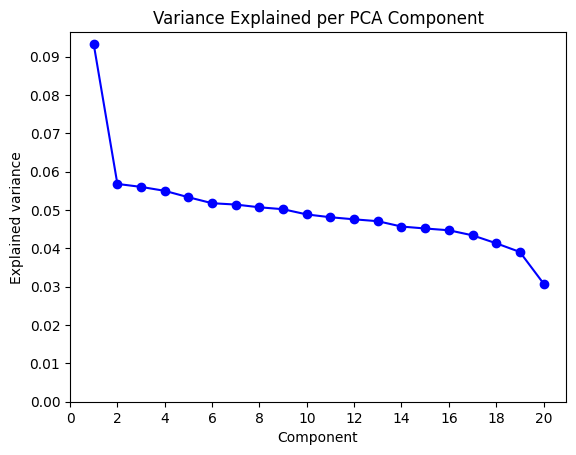

In [51]:
point_est_PCA = point_est.iloc[:,0:20] # Dropping cluster column from previous attempt

# Standardize the data (scaling the PACF values)
scaler = StandardScaler()
point_est_PCA.columns = point_est_PCA.columns.astype(str)

point_est_PCA = pd.DataFrame(scaler.fit_transform(point_est_PCA), columns=point_est_PCA.columns, index=point_est_PCA.index)

# Optional: If you'd like to use PCA for dimensionality reduction before clustering
pca = PCA(n_components=20)
point_est_PCA = pca.fit_transform(point_est_PCA)

column_titles = [f'PCA{i}' for i in range(1,21)]

# Convert PCA result back to DataFrame to work with clustering functions
point_est_PCA = pd.DataFrame(point_est_PCA, columns=[column_titles], index=point_est.index)

explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()
print(f"Explained variance by each component: {explained_variance}")
print(f"Total explained variance: {total_explained_variance:.2f}")

plt.plot(range(1, 21), explained_variance, marker='o', color='blue')
plt.title('Variance Explained per PCA Component')
plt.xlabel('Component')
plt.ylabel('Explained variance')
plt.xticks(range(0, 21, 2))  # To label each component from 1 to 20
plt.yticks(np.arange(0,.1, .01))
plt.show()


From this chart, we can see the first component explains significantly more variance than the following components. However, each component is still relatively valuable. Thus, it appears relatively unfruitful to drastically decrease the dimensionality of our data. 

Out of curiosity, we will reduce our data to two dimensions, even though they only explain 15% of variance, and redo the clustering. 

In [52]:
dimension_count = 2

Explained variance by each component: [0.09323954 0.05678443]
Total explained variance: 0.15
WCSS for 10 clusters: 6925.886102359303


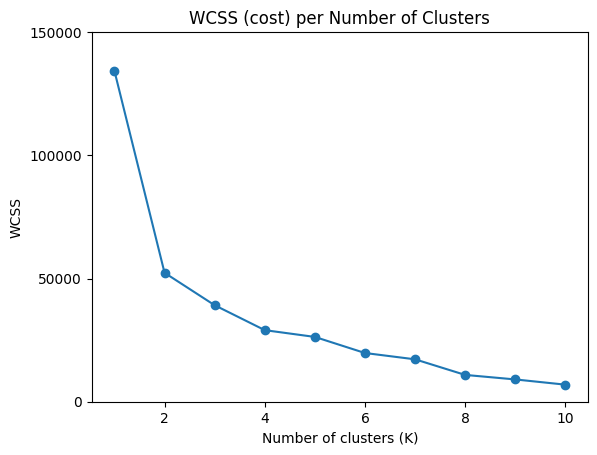

In [53]:
# Standardize the data (scaling the PACF values)
scaler = StandardScaler()
point_est_PCA = pd.DataFrame(scaler.fit_transform(point_est), columns=point_est.columns, index=point_est.index)
# Optional: If you'd like to use PCA for dimensionality reduction before clustering
pca = PCA(n_components=dimension_count)
point_est_PCA = pca.fit_transform(point_est_PCA)

column_titles = [f'PCA{i}' for i in list(range(1,dimension_count+1))]

# Convert PCA result back to DataFrame to work with clustering functions
point_est_PCA = pd.DataFrame(point_est_PCA, columns=[column_titles], index=point_est.index)

explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()
print(f"Explained variance by each component: {explained_variance}")
print(f"Total explained variance: {total_explained_variance:.2f}")

# Apply K-Means clustering to the PCA-transformed data
kmeans = KMeans(n_clusters=10, random_state=42)  # Adjust n_clusters as needed
point_est_PCA['cluster'] = kmeans.fit_predict(point_est_PCA)

# Calculate WCSS (Within-Cluster Sum of Squares)
wcss = kmeans.inertia_

print(f"WCSS for {10} clusters: {wcss}")

wcss_scores = []
for k in range(1, 11):  # You can adjust the range of K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(point_est_PCA)  # Fit on the PCA-transformed data
    wcss_scores.append(kmeans.inertia_)

# Plot WCSS for different values of K (Elbow Method)
plt.plot(range(1, 11), wcss_scores, marker='o')
plt.title('WCSS (cost) per Number of Clusters')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.yticks(range(0, 200000, 50000))
plt.show()


Again applying the elbow heuristic, we set our k=2

In [54]:
PCA_cluster_count = 2

Explained variance by each component: [0.09323954 0.05678443]
Total explained variance: 0.15


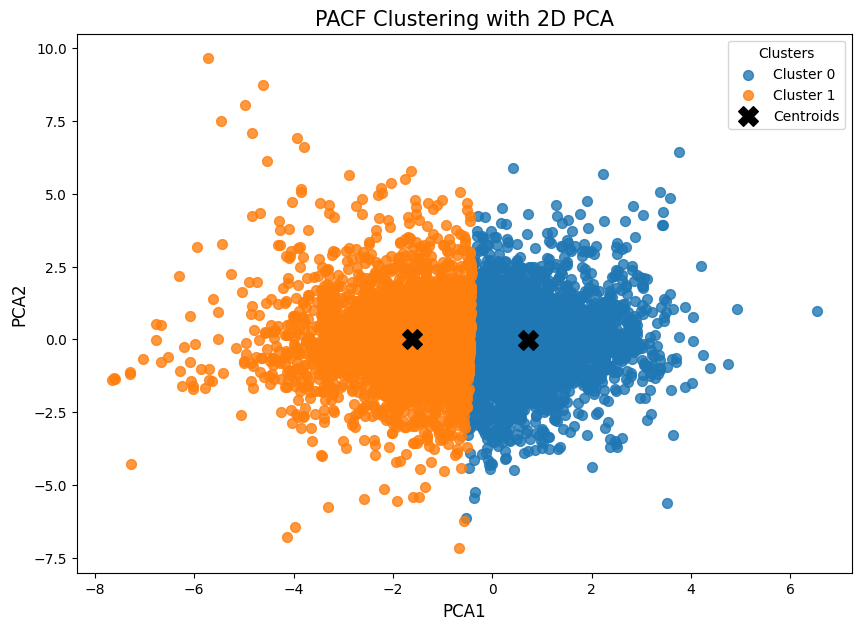

In [63]:
# Standardize the data (scaling the PACF values)
scaler = StandardScaler()
point_est_scaled = pd.DataFrame(scaler.fit_transform(point_est), columns=point_est.columns, index=point_est.index)

# Optional: If you'd like to use PCA for dimensionality reduction before clustering
pca = PCA(n_components=dimension_count)
point_est_PCA = pca.fit_transform(point_est_scaled)

column_titles = [f'PCA{i}' for i in range(1,dimension_count+1)]

# Convert PCA result back to DataFrame to work with clustering functions
point_est_PCA = pd.DataFrame(point_est_PCA, columns=column_titles, index=point_est.index)

explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()
print(f"Explained variance by each component: {explained_variance}")
print(f"Total explained variance: {total_explained_variance:.2f}")

# Apply K-Means clustering to the PCA-transformed data
kmeans = KMeans(n_clusters=PCA_cluster_count, random_state=42)  # Adjust n_clusters as needed
point_est_PCA['cluster'] = kmeans.fit_predict(point_est_PCA)

plt.figure(figsize=(10, 7))
for cluster in range(PCA_cluster_count):
    cluster_data = point_est_PCA[point_est_PCA['cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], 
                label=f'Cluster {cluster}', s=50, alpha=0.8)


centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0], centroids[:,1], 
            color='black', s=200, marker='X', label='Centroids')

# Add legend and labels
plt.legend(title="Clusters")
plt.title('PACF Clustering with 2D PCA', fontsize=15)
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.show()

From this output, we can see that we aren't capturing two distinct clusters, but rather two halves of an oval-shaped cluster. 

In [64]:
cluster_merge_PCA = pd.merge((point_est.iloc[:, 0:20]), point_est_PCA['cluster'], left_index=True, right_index=True, how='left')
cluster_merge_PCA.reset_index(drop=True, inplace=True)
cluster_merge_PCA.set_index(cluster_merge_PCA.loc[:, 'cluster'], inplace=True)
cluster_merge_PCA = cluster_merge_PCA.iloc[:, list(range(0,20))]
cluster_groups_PCA = cluster_merge_PCA.groupby(cluster_merge_PCA.index)
cluster_groups_PCA.size()

cluster
0    8628
1    3894
dtype: int64

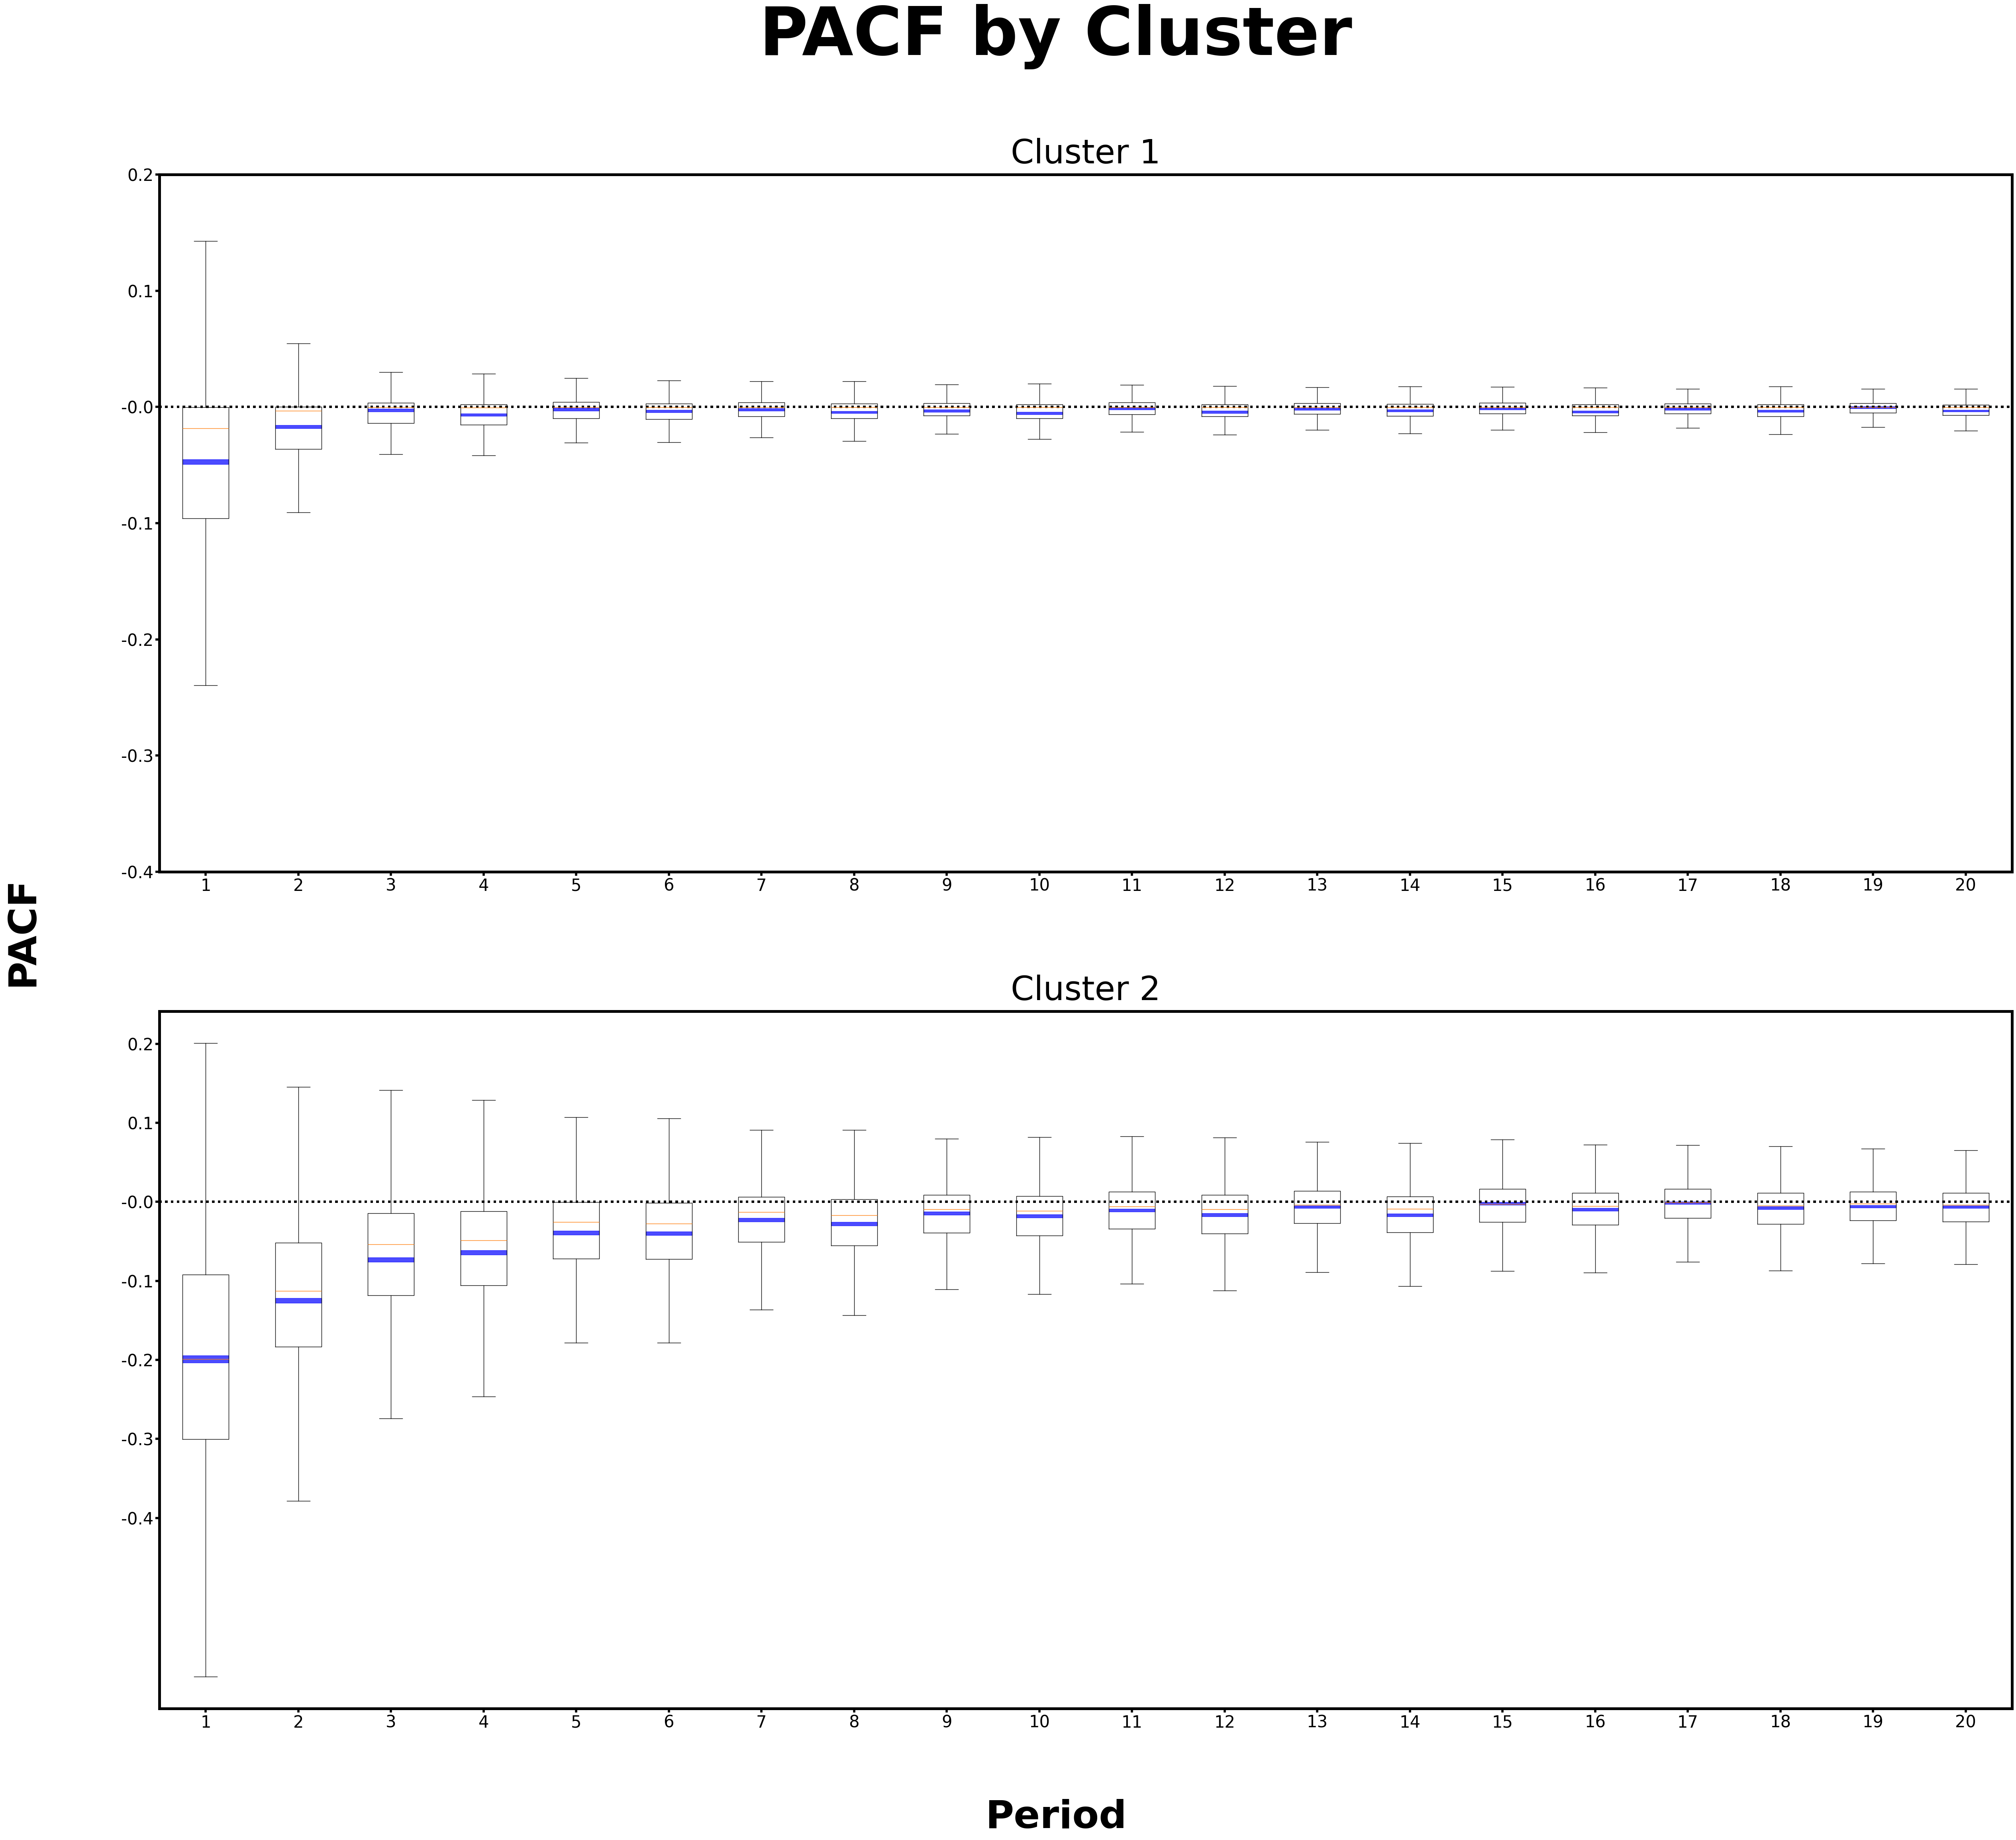

In [65]:
fig, ax_clustered = plt.subplots(nrows=PCA_cluster_count, ncols=1, figsize=(60,50))

ax_clustered=ax_clustered.flatten()

for i, (group_name, group) in enumerate(cluster_groups_PCA):
    
    ax_clustered[i].boxplot(group, showfliers=False)    
    for z in range(group.shape[1]):
        mean = np.mean(group.iloc[:, z])
        sem = stats.sem(group.iloc[:, z])
        ax_clustered[i].fill_between([z + 1 - 0.25, z + 1 +.25], mean - 1.96*sem, mean + 1.96*sem, alpha = .7, color = 'blue')

        ax_clustered[i].set_title(f'Cluster {i+1}', fontsize=60, pad=20)
        ax_clustered[i].set_xticks(range(1, 21))
        ax_clustered[i].set_xticklabels(range(1,21), size = 30)
        ax_clustered[i].set_yticks(np.arange(-.4,.3,0.1))
        ax_clustered[i].set_yticklabels(np.arange(-.4,.3,0.1).round(2),size=30)
        for spine in ax_clustered[i].spines.values():
            spine.set_linewidth(5)
        ax_clustered[i].tick_params(axis='both', width = 4, length = 7)
        ax_clustered[i].axhline(y=0, color='black', linestyle=':', linewidth=4)

fig.text(0.5, .94, 'PACF by Cluster', ha='center', fontsize=120, fontweight='bold')
fig.text(0.06, 0.5, 'PACF', va='center', rotation='vertical', fontsize=70, fontweight='bold')
fig.text(0.5, 0.05, 'Period', ha='center', fontsize=70, fontweight='bold')
plt.show()

As expected, given the plot showing the explained variance per component, the 2D data results in clusters that capture only a muted version of the effect seen in the clusters from the raw data. 

Again, to prove a statistically significant difference between clusters, we can apply a MANOVA test. 

In [66]:
manova_df_PCA = cluster_merge_PCA.reset_index()
manova_df_PCA.columns = new_columns
manova_df_PCA.head()

,cluster,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20
0,1,-0.159830,-0.384927,-0.044841,0.025583,-0.006164,-0.057641,0.041232,0.009801,0.036710,...,-0.014412,-0.009913,-0.003620,0.008005,-0.024037,0.020674,-0.010660,0.005924,-0.047206,-0.024943
1,0,-0.138310,-0.022690,-0.003653,-0.000909,0.000178,-0.002349,0.002385,0.000798,0.000195,...,0.001948,-0.002251,-0.003863,-0.001391,-0.000203,-0.000063,-0.008275,0.004334,0.005214,-0.003343
2,0,-0.024058,-0.002642,0.000180,-0.002025,-0.000944,-0.005381,-0.050222,0.020589,0.048028,...,-0.002219,-0.012523,-0.001006,-0.021273,-0.022564,0.008596,-0.001739,-0.002792,-0.015083,-0.022552
3,1,-0.410209,-0.202681,-0.104669,-0.054670,-0.028659,-0.015202,-0.008083,-0.004315,-0.002322,...,-0.000636,-0.000337,-0.000198,-0.000133,-0.034566,0.081597,0.095057,0.078197,0.056646,0.038469
4,0,-0.004583,0.000402,-0.005879,0.000087,-0.000039,0.010691,-0.006933,-0.000114,0.000128,...,0.011491,0.005446,0.000553,0.001486,-0.005605,0.000025,-0.001327,0.048336,0.001599,0.005322


In [67]:
dependent_vars = ' + '.join(new_columns[1:21])
formula = f"{dependent_vars} ~ cluster"
manova_PCA = MANOVA.from_formula(formula, data=manova_df_PCA)
manova_PCA_result = manova_PCA.mv_test()
print(manova_PCA_result)

                    Multivariate linear model
                                                                  
------------------------------------------------------------------
        Intercept        Value   Num DF   Den DF   F Value  Pr > F
------------------------------------------------------------------
           Wilks' lambda 0.8146 20.0000 12501.0000 142.2495 0.0000
          Pillai's trace 0.1854 20.0000 12501.0000 142.2495 0.0000
  Hotelling-Lawley trace 0.2276 20.0000 12501.0000 142.2495 0.0000
     Roy's greatest root 0.2276 20.0000 12501.0000 142.2495 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
        cluster         Value   Num DF   Den DF    F Value  Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.3671 20.0000 12501.0000 1077.8013 0.0000
         Pillai'

Similar to the non-PCA data, we see a statistically significant difference between the two clusters at a 5% significance level. 

# Conclusion

Applying the PACF to polymarket price midpoint data, followed by k-means clustering, we were able to identify two significantly different groups. 

The first demonstrated negative autocorrelation between the first differences of price at differing lags. This is consistent with markets that exhibit short-term reversal. 

The second demonstrated significantly less negative autocorrelation. This group was closer to a theoretical "efficient" market.

The lack of a "momentum" cluster may mean that the timescale on which momentum occurs in prediction markets is similar to that of traditional markets, but this would require further analysis. 

For further research, to predict which cluster a market may fall in, the "inefficient" short-term reversing group or the "efficient" random group, one could see how liquidity and volume affect PACF values. 